In [79]:
# For data processing
from tensorflow.keras.layers import Dense, LSTM, Dropout, PReLU, RepeatVector, TimeDistributed, Attention
import gc
import os
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, Callback
from keras.layers.merge import concatenate
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import SimpleRNN as Recurrent
from tensorflow.keras import regularizers, constraints, initializers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras import backend
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from scipy.stats import hmean
import json
from os import path
import numpy as np
import math
from math import sqrt

# For data processing and manipulation
import pandas as pd
import csv

# For date calculations
import datetime
import time

# For ploting data
import IPython
import IPython.display

import itertools
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# For checking path


#tensorflow libs

#from keras.layers.recurrent import Recurrent, _time_distributed_dense
#from tensorflow.compat.v1.keras.layers import RNN


tf.get_logger().setLevel('ERROR')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [2]:
ROOTPATH = r"C:\Users\Administrator\Desktop\my research(Shakib)\BD_Weather"
MODEL_PATH = ROOTPATH+"/models"
HISTORY_PATH = ROOTPATH+"/histories"

In [3]:
dataset = pd.read_csv('datasets/all_the_data_V3.csv')
dataset['date'] = pd.to_datetime(dict(year=dataset.year, month=dataset.month, day=dataset.day))
dataset.head()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0 station_name  year  month  day  rain_fall sunshine humidity  \
0           0        dhaka  1977      1    1        0.0       10       59   
1           1        dhaka  1977      1    2        0.0     10.1       62   
2           2        dhaka  1977      1    3        0.0      9.9       67   
3           3        dhaka  1977      1    4        0.0       10       68   
4           4        dhaka  1977      1    5        0.0      9.5       69   

   temperature  wind_speed wind_direction       date  
0         17.3         3.5             NW 1977-01-01  
1         17.3         4.0             NW 1977-01-02  
2         17.5         3.2             NW 1977-01-03  
3         17.5         2.0             NW 1977-01-04  
4         16.5         2.0             NW 1977-01-05

In [4]:
print(dataset.columns)
for x in dataset.columns:
    print(x)
    types = set([type(y) for y in dataset[x]])
    print(types)

Index(['Unnamed: 0', 'station_name', 'year', 'month', 'day', 'rain_fall',
       'sunshine', 'humidity', 'temperature', 'wind_speed', 'wind_direction',
       'date'],
      dtype='object')
Unnamed: 0
{<class 'int'>}
station_name
{<class 'str'>}
year
{<class 'int'>}
month
{<class 'int'>}
day
{<class 'int'>}
rain_fall
{<class 'float'>}
sunshine
{<class 'float'>, <class 'str'>}
humidity
{<class 'float'>, <class 'str'>, <class 'int'>}
temperature
{<class 'float'>}
wind_speed
{<class 'float'>}
wind_direction
{<class 'str'>}
date
{<class 'pandas._libs.tslibs.timestamps.Timestamp'>}


In [5]:
sum_columns = {}
cnt_columns = {}

sum_columns["humidity"] = 0
sum_columns["sunshine"] = 0
cnt_columns["humidity"] = 0
cnt_columns["sunshine"] = 0

def convert_to_float(x , key):
    x = str(x)
    x = x.strip()
    
    x = x.strip()
    if(len(x)==0):
        if(cnt_columns[key]!=0):
            return float(sum_columns[key]/cnt_columns[key])
        else:
            return 0.0
    else:
        cnt_columns[key]+=1
        sum_columns[key]+=float(x)
        return float(x)
    
data_fields = {
    'humidity': lambda x: convert_to_float(x , "humidity"),
    'sunshine': lambda x: convert_to_float(x , "sunshine"),
}
for x in data_fields.keys():
    dataset[x] = dataset[x].apply(data_fields[x])


In [6]:
print(dataset.columns)
for x in dataset.columns:
    print(x)
    types = set([type(y) for y in dataset[x]])
    print(types)


Index(['Unnamed: 0', 'station_name', 'year', 'month', 'day', 'rain_fall',
       'sunshine', 'humidity', 'temperature', 'wind_speed', 'wind_direction',
       'date'],
      dtype='object')
Unnamed: 0
{<class 'int'>}
station_name
{<class 'str'>}
year
{<class 'int'>}
month
{<class 'int'>}
day
{<class 'int'>}
rain_fall
{<class 'float'>}
sunshine
{<class 'float'>}
humidity
{<class 'float'>}
temperature
{<class 'float'>}
wind_speed
{<class 'float'>}
wind_direction
{<class 'str'>}
date
{<class 'pandas._libs.tslibs.timestamps.Timestamp'>}


In [7]:
wind_direction = np.array(dataset['wind_direction'].unique(), str)
print(wind_direction)

['NW' 'W' 'SW' 'N' 'NE' 'CLM' 'S' 'SE' 'E' 'NNE' 'WNW' 'SSW' 'NNW' 'WSW'
 'SSE' 'ESE' 'ENE']


In [8]:
def degToCompass(num):
    val=int((num/22.5)+.5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    # print(arr[(val % 16)])
    return arr[(val % 16)]

# not sure if it's correct way to do this
# found the degToCompass in stackoverflow
# tried to make a reverse
def compassToDeg(compass):
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    index = 0
    for i in range(len(arr)):
        if(arr[i]==compass):
            index=i
            break
    return (index-0.5)*22.5

In [9]:
dataset['wind_direction'] = dataset['wind_direction'].apply(lambda x: compassToDeg(x))
wind_direction = np.array(dataset['wind_direction'].unique(), str)
print(wind_direction)


['303.75' '258.75' '213.75' '-11.25' '33.75' '168.75' '123.75' '78.75'
 '11.25' '281.25' '191.25' '326.25' '236.25' '146.25' '101.25' '56.25']


#### Wind
The last column of the data, `wind_direction`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

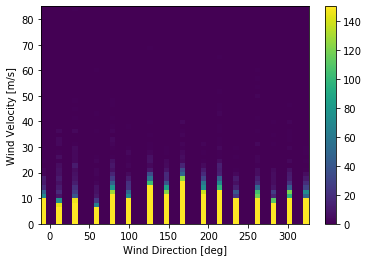

In [10]:
plt.hist2d(dataset['wind_direction'], dataset['wind_speed'], bins=(50, 50), vmax=150)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')


In [11]:
wv = dataset['wind_speed']

# Convert to radians.
wd_rad = dataset['wind_direction']*np.pi / 180

# Calculate the wind x and y components.
dataset['Wx'] = wv*np.cos(wd_rad)
dataset['Wy'] = wv*np.sin(wd_rad)

(-54.876994411967985,
 70.67491704571634,
 -58.84711682419382,
 57.620844132566376)

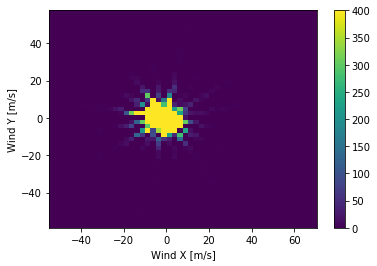

In [12]:
plt.hist2d(dataset['Wx'], dataset['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [13]:
# print(dataset.columns)
for x in dataset.columns:
    print(x)
    types = set([type(y) for y in dataset[x]])
    print(types)


Unnamed: 0
{<class 'int'>}
station_name
{<class 'str'>}
year
{<class 'int'>}
month
{<class 'int'>}
day
{<class 'int'>}
rain_fall
{<class 'float'>}
sunshine
{<class 'float'>}
humidity
{<class 'float'>}
temperature
{<class 'float'>}
wind_speed
{<class 'float'>}
wind_direction
{<class 'float'>}
date
{<class 'pandas._libs.tslibs.timestamps.Timestamp'>}
Wx
{<class 'float'>}
Wy
{<class 'float'>}


In [14]:
dataset.drop("Unnamed: 0" , 1 , inplace=True)
# dataset.drop("station_name" , 1 , inplace=True)
dataset.drop("year" , 1 , inplace=True)
dataset.drop("month" , 1 , inplace=True)
dataset.drop("day" , 1 , inplace=True)
# dataset.drop("wind_direction" , 1 , inplace=True)

In [15]:
cities = np.array(dataset['station_name'].unique() , str)
cities

array(['dhaka', 'tangail', 'mymensingh', 'faridpur', 'madaripur',
       'srimangal', 'sylhet', 'bogra', 'dinajpur', 'ishurdi', 'rajshahi',
       'rangpur', 'sydpur', 'chuadanga', 'jessore', 'khulna', 'mongla',
       'satkhira', 'barisal', 'bhola', 'khepupara', 'patuakhali',
       'chandpur', 'teknaf', 'chittagong', 'comilla', 'coxsbazar', 'feni',
       'hatiya', 'kutubdia', 'mcourt', 'rangamati', 'sandwip',
       'ambaganctg', 'sitakunda'], dtype='<U10')

In [16]:
dataset_city ={}
for x in cities:
    dataset_city[x] = dataset[(dataset.station_name == x)]

In [17]:
for x in cities:
    dates = np.array(dataset_city[x]['date'].unique(), str)
    print(x , dataset_city[x].shape , len(dates))
    dataset_city[x].drop("station_name" , 1 , inplace=True)
    dataset_city[x].to_csv("datasets/"+x+".csv")

dhaka (14934, 10) 14934


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


tangail (11807, 10) 11807
mymensingh (14629, 10) 14539
faridpur (12565, 10) 12565
madaripur (12473, 10) 12109
srimangal (12292, 10) 12292
sylhet (15631, 10) 15631
bogra (15357, 10) 15267
dinajpur (11199, 10) 11199
ishurdi (12626, 10) 12626
rajshahi (14569, 10) 14569
rangpur (14873, 10) 14873
sydpur (7224, 10) 7224
chuadanga (8579, 10) 7618
jessore (14812, 10) 14812
khulna (12991, 10) 12991
mongla (6920, 10) 6920
satkhira (12991, 10) 12991
barisal (15570, 10) 15570
bhola (14205, 10) 14205
khepupara (11625, 10) 11625
patuakhali (12626, 10) 12626
chandpur (14508, 10) 14508
teknaf (15115, 10) 15115
chittagong (13385, 10) 13385
comilla (13325, 10) 13325
coxsbazar (15631, 10) 15631
feni (12626, 10) 12626
hatiya (11169, 10) 11169
kutubdia (12748, 10) 12748
mcourt (12748, 10) 12748
rangamati (11986, 10) 11958
sandwip (11534, 10) 11534
ambaganctg (4371, 10) 4371
sitakunda (15206, 10) 15206


In [18]:
features = ["rain_fall" , "sunshine" , "humidity" , "temperature" , "wind_speed" , "wind_direction" , "date"]

In [19]:
dataset_city['dhaka'].head()

rain_fall  sunshine  humidity  temperature  wind_speed  wind_direction  \
0        0.0      10.0      59.0         17.3         3.5          303.75   
1        0.0      10.1      62.0         17.3         4.0          303.75   
2        0.0       9.9      67.0         17.5         3.2          303.75   
3        0.0      10.0      68.0         17.5         2.0          303.75   
4        0.0       9.5      69.0         16.5         2.0          303.75   

        date        Wx        Wy  
0 1977-01-01  1.944496 -2.910144  
1 1977-01-02  2.222281 -3.325878  
2 1977-01-03  1.777825 -2.660703  
3 1977-01-04  1.111140 -1.662939  
4 1977-01-05  1.111140 -1.662939

In [20]:
def dateTimeToSignal(df):
    '''
    Converts the DateTime index to timestamp and convert it to signal (sine and cosine) to deal with periodicity
    input: 
        df : Dataset
    Output:
        df : Dataset with column Day sin , Day cos , Week sin , Week cos ,  Year sin , Year cos ; representing Sin / Cosine signal for timestamp  
    '''
    timestamp_s = df.index.map(datetime.datetime.timestamp)
    day = 24*60*60
    week = 7*day
    year = (365.2425)*day

    # df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    # df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
    df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

    # df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    return df


In [21]:
dataset_city = {}
for x in cities:
    dataset_city[x] = pd.read_csv("datasets/"+x+".csv", header=0,infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
    dataset_city[x].drop("Unnamed: 0" , 1 , inplace=True)
    dataset_city[x].drop("wind_speed" , 1 , inplace=True)
    dataset_city[x].drop("wind_direction" , 1 , inplace=True)
    dataset_city[x] = dateTimeToSignal(dataset_city[x])
    # dataset_city[x].drop("day " , 1 , inplace=True)


In [22]:
# print(dataset.columns)
for x in dataset_city['madaripur'].columns:
    print(x)
    types = set([type(y) for y in dataset_city["madaripur"][x]])
    print(types)


rain_fall
{<class 'float'>}
sunshine
{<class 'float'>}
humidity
{<class 'float'>}
temperature
{<class 'float'>}
Wx
{<class 'float'>}
Wy
{<class 'float'>}
Day cos
{<class 'float'>}
Week cos
{<class 'float'>}
Year cos
{<class 'float'>}


In [23]:
def split_data(df):
    '''
    split the dataset ( train , val , test = (70 , 15 , 15)% )
    input:
        df : Dataset to split
    output:
        train_df : train dataset
        val_df : validation dataset
        test_df : test dataset
        num_features : Number of features in dataset
        column_indices : column_indices in dataset
    '''
    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.85)]
    test_df = df[int(n*0.85):]

    num_features = df.shape[1]
    return train_df, val_df, test_df, num_features, column_indices


In [24]:
def create_data(train, test, val, columns):
    '''
    Create dataset from main train , test , val with given columns
    '''
    if(columns == None):
        columns = train.columns
    new_train = train[columns]
    new_test = test[columns]
    new_val = val[columns]
    return new_train, new_test, new_val


In [25]:
def normalize_MinMax(train , val , test):
    train_max = train.max()
    train_min = train.min()
    
    train = (train - train_min)/(train_max - train_min)
    val = (val - train_min)/ (train_max - train_min)
    test = (test - train_min) / (train_max - train_min)
    return train , val , test , train_max , train_min

In [26]:
def normalize_std(train , val , test):
    train_mean = train.mean()
    train_std = train.std()
    train = (train - train_mean) / train_std
    val = (val - train_mean) / train_std
    test = (test - train_mean) / train_std
    return train , val ,test , train_mean , train_std

In [27]:
class WindowGenerator():
    '''
    WindowGenerator Class
    1. Split windows of features into a (features, labels) pairs.
    2. Plot the content of the resulting windows.
    3. Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets S.
    '''
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None , shuffle=False , batch_size = 64):
        '''
        The __init__ method includes all the necessary logic for the input and label indices.
        Input: 
            input_width : input width / window size 
            label_width : output width
            shift : size of window shifting forward
            train_df : train dataset
            val_df : validation dataset
            test_df : test dataset
            label_columns ( Default = None) : Label Columns
            shuffle ( Default = False) : weather to shuffle data 
            batch_size (Default = 64) : Batch Size
        Output: None
        Example :
            w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['count'])
            w2

        '''
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.shuffle = shuffle
        self.batch_size = batch_size

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}


        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #(start , stop)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        '''
        Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.
        
        Input: 
            features : Stack of array of datas , used for splitting data to inputs and labels
        Output:
            inputs : nd Array splitted as input_width
            labesl : nd Array splitted as label_width
        Example :
        # Stack three slices, the length of the total window:
            example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


            example_inputs, example_labels = w2.split_window(example_window)

            print('All shapes are: (batch, time, features)')
            print(f'Window shape: {example_window.shape}')
            print(f'Inputs shape: {example_inputs.shape}')
            print(f'labels shape: {example_labels.shape}')
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        #taking only the labels that are presentin the label_columns
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='temperature', max_subplots=3):
        '''
            plot method that allows a simple visualization of the split window,
            Input:
                model (Default=None) : tensorflow model to evaluate 
                plot_col ( Default = 'count') : Name of column to evaluate
                max_subplots ( Default = 3) : Maximum Number of subplotting
            Output:
                None
            Example:
                w2.plot()
                w2.plot(plot_col=0) # label wont be shown as w2 config has only column , count 

        '''
        inputs, labels = self.example
        plt.figure(figsize=(15, 12))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        '''
        make_dataset method will take a time series DataFrame and convert it to a
            tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function.
        Input:
            data :  Input data to transform into (input_window , label_window)
        Output:
            ds : transformed dataset
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=self.shuffle,
            batch_size=self.batch_size,)
        ds = ds.map(self.split_window)
        return ds
    
    def create_dataset2(self , map_df , reshape=True):
      x = []
      y = []
      for res in iter(map_df):
        inputs, labels = res
        if(len(inputs)==64):
          x.append(inputs)
          y.append(labels)
      
      x = np.array(x)
      y = np.array(y)
      if(reshape):
        x = x.reshape(-1, x.shape[-2] , x.shape[-1])
        y = y.reshape(-1 , y.shape[-2] , y.shape[-1])
      return x , y
    
    '''
    properties for accessing  training, validation and test data as tf.data.Datasets using the above make_dataset method.
    Also a standard example batch for easy access and plotting
    '''

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

In [28]:
dataset_city['dhaka'].columns

Index(['rain_fall', 'sunshine', 'humidity', 'temperature', 'Wx', 'Wy',
       'Day cos', 'Week cos', 'Year cos'],
      dtype='object')

In [29]:
y_col = ['rain_fall', 'sunshine', 'humidity', 'temperature', 'Wx', 'Wy']
print(features , len(dataset_city['dhaka'].columns))


['rain_fall', 'sunshine', 'humidity', 'temperature', 'wind_speed', 'wind_direction', 'date'] 9


In [30]:
def save_history(history , path):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    # or save to csv: 
    hist_csv_file = path
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_json(f)

def get_history(path):
    with open(path) as json_file:
        data = json.load(json_file)
        return data

def save_model_weights(model , path):
  model.save_weights(path)


In [31]:
def sMAPE(y, y_pred):
    epsilon = 0.1
    summ = backend.maximum(backend.abs(
        y) + backend.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = backend.abs(y_pred - y) / summ * 2.0
    return smape


In [32]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

In [33]:
metrics_name = ['mae' , 'msle' , 'mse' , 'smape' , 'r^2']

In [34]:
def compileModel(model):
    model.compile(loss=tf.losses.MeanAbsoluteError(), optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanSquaredLogarithmicError(), tf.metrics.MeanSquaredError(), sMAPE, R_squared])
    return model


In [35]:
MAX_EPOCHS = 20
from keras.callbacks import ModelCheckpoint
def compile_and_fit(model, modelPath , historyPath , window=None, name=None , patience=10):
    '''
    Compile and fit a model
    '''
    modelPathPar = MODEL_PATH+'/'+modelPath+'/'
    historyPathPar = HISTORY_PATH+'/'+historyPath+'/'
    if (name!=None):
        # model_path = ROOTPATH+'/model_all_mae_swish/'+name
        # history_path = ROOTPATH+'/history_all_mae_swish/'+name+".json"
        model_path = modelPathPar+name
        history_path = historyPathPar+name+".json"
        
        if not path.exists(modelPathPar):
            os.makedirs(modelPathPar)
        if not path.exists(historyPathPar):
            os.makedirs(historyPathPar)

    if (name!=None and path.exists(model_path)):
      print("Loaded Pre Trained Model")
      modelOld = tf.keras.models.load_model(model_path, custom_objects={
                                            'sMAPE': sMAPE, "R_squared": R_squared})
      model.set_weights(modelOld.get_weights())
      history = get_history(history_path)
      return model , history
      
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience)
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True,mode='min',save_weights_only=False)
    history = model.fit(window.train, epochs=MAX_EPOCHS,validation_data=window.val,callbacks=[early_stopping,checkpoint])
    if(name!=None):
      model.save(model_path)
      save_history(history , history_path)
    return model , history.history


In [36]:
def generate_window(df_now, ret_test = 0):
    train_df , val_df , test_df , num_features_df , column_indices_df = split_data(df_now)
    train_df , test_df , val_df = create_data(train_df , test_df , val_df , None)
    train_df , val_df , test_df , train_mean , train_std = normalize_std(train_df , val_df , test_df)

    wide_window_all = WindowGenerator(train_df=train_df, test_df=test_df , val_df=val_df, 
        input_width=14, label_width=14, shift=1,
        label_columns=y_col)
    print(train_std , train_mean)
    print(train_df.head())
    if (ret_test == 1):
      return wide_window_all, test_df, train_mean, train_std
    else:  
      return wide_window_all, train_mean, train_std

In [100]:
input_bi_lstm = keras.Input(shape=(14,9), name="input_BiLSTM")
x_bd = (keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation = tf.keras.activations.swish ,return_sequences=True) , name="bilstm1"))(input_bi_lstm)
x_bd = (keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation = tf.keras.activations.swish ,return_sequences=True) , name="bilstm2"))(x_bd)
x_bd = (keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation = tf.keras.activations.swish ,return_sequences=True) , name="bilstm3"))(x_bd)
x_bd = (TimeDistributed(keras.layers.Dense(units=16, activation = tf.keras.activations.swish), name="TimeDisDenseLSTM"))(x_bd)
output_bi_lstm = (keras.layers.Dense(units=len(y_col)))(x_bd)
 
bi_lstm_model_all_feature = keras.Model(
    inputs=[input_bi_lstm],
    outputs=[output_bi_lstm],
)
bi_lstm_model_all_feature.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_BiLSTM (InputLayer)   [(None, 14, 9)]           0         
                                                                 
 bilstm1 (Bidirectional)     (None, 14, 64)            10752     
                                                                 
 bilstm2 (Bidirectional)     (None, 14, 64)            24832     
                                                                 
 bilstm3 (Bidirectional)     (None, 14, 64)            24832     
                                                                 
 TimeDisDenseLSTM (TimeDistr  (None, 14, 16)           1040      
 ibuted)                                                         
                                                                 
 dense_20 (Dense)            (None, 14, 6)             102       
                                                           

In [ ]:
# Load Attn_LSTM MODEL
val_performance_bi_lstm = {}
performance_bi_lstm = {}
histories = {}
attn_lstm_model_all_feature = compileModel(bi_lstm_model_all_feature)
for x in cities:
    wide_window_all , train_max , train_min = generate_window(dataset_city[x])
    x = str(x)
    print(x)
    
    # if(key<5):
    bi_lstm_model_all_feature, history = compile_and_fit(
        bi_lstm_model_all_feature, "model_lstm_"+x, "history_lstm", name='Bi_LSTM_'+x, window=wide_window_all)
    histories["lstm_all"+x] = history
    # print(attn_lstm_model_all_feature.summary())
    # print(attn_lstm_model_all_feature.layers)
    
    val_performance_bi_lstm[x] = attn_lstm_model_all_feature.evaluate(wide_window_all.val)
    performance_bi_lstm[x] = attn_lstm_model_all_feature.evaluate(wide_window_all.test)

    IPython.display.clear_output()


rain_fall      1.447587e+01
sunshine       3.215037e+00
humidity       8.423328e+00
temperature    4.284030e+00
Wx             3.093090e+00
Wy             2.239227e+00
Day cos        3.312777e-12
Week cos       7.071058e-01
Year cos       7.087038e-01
dtype: float64 rain_fall      4.956225e+00
sunshine       6.680529e+00
humidity       7.933451e+01
temperature    2.565137e+01
Wx            -1.225575e+00
Wy             3.822418e-01
Day cos       -3.369181e-12
Week cos       8.889500e-05
Year cos       6.676672e-03
dtype: float64
            rain_fall  sunshine  humidity  temperature        Wx        Wy  \
date                                                                         
1985-01-01  -0.342378 -0.429397  0.910031    -1.996104  1.506042 -0.475637   
1985-01-02  -0.204217  0.083816  0.435160    -1.575939  0.216613  0.200617   
1985-01-03  -0.342378  0.130472  0.197724    -1.552597  1.030408 -0.344951   
1985-01-04  -0.342378 -0.647124 -0.277148    -1.412542  1.315788 -0.423362  

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

138/138 [==============================] - 43s 312ms/step - loss: 0.0898 - mean_squared_logarithmic_error: 0.0062 - mean_squared_error: 0.0452 - sMAPE: 0.1439 - R_squared: 0.9540 - val_loss: 0.0792 - val_mean_squared_logarithmic_error: 0.0047 - val_mean_squared_error: 0.0292 - val_sMAPE: 0.1424 - val_R_squared: 0.9593
Epoch 2/20
137/138 [============================>.] - ETA: 0s - loss: 0.0874 - mean_squared_logarithmic_error: 0.0060 - mean_squared_error: 0.0439 - sMAPE: 0.1397 - R_squared: 0.9549
Epoch 2: val_loss did not improve from 0.07925
138/138 [==============================] - 8s 61ms/step - loss: 0.0874 - mean_squared_logarithmic_error: 0.0060 - mean_squared_error: 0.0439 - sMAPE: 0.1396 - R_squared: 0.9551 - val_loss: 0.0796 - val_mean_squared_logarithmic_error: 0.0048 - val_mean_squared_error: 0.0292 - val_sMAPE: 0.1502 - val_R_squared: 0.9594
Epoch 3/20
137/138 [============================>.] - ETA: 0s - loss: 0.0901 - mean_squared_logarithmic_error: 0.0061 - mean_squared

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.e

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

138/138 [==============================] - 43s 314ms/step - loss: 0.0886 - mean_squared_logarithmic_error: 0.0061 - mean_squared_error: 0.0434 - sMAPE: 0.1433 - R_squared: 0.9552 - val_loss: 0.0687 - val_mean_squared_logarithmic_error: 0.0042 - val_mean_squared_error: 0.0271 - val_sMAPE: 0.1216 - val_R_squared: 0.9624
Epoch 5/20
137/138 [============================>.] - ETA: 0s - loss: 0.0861 - mean_squared_logarithmic_error: 0.0060 - mean_squared_error: 0.0429 - sMAPE: 0.1387 - R_squared: 0.9557
Epoch 5: val_loss improved from 0.06873 to 0.06826, saving model to C:\Users\Administrator\Desktop\my research(Shakib)\BD_Weather/models/model_lstm_faridpur\Bi_LSTM_faridpur
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


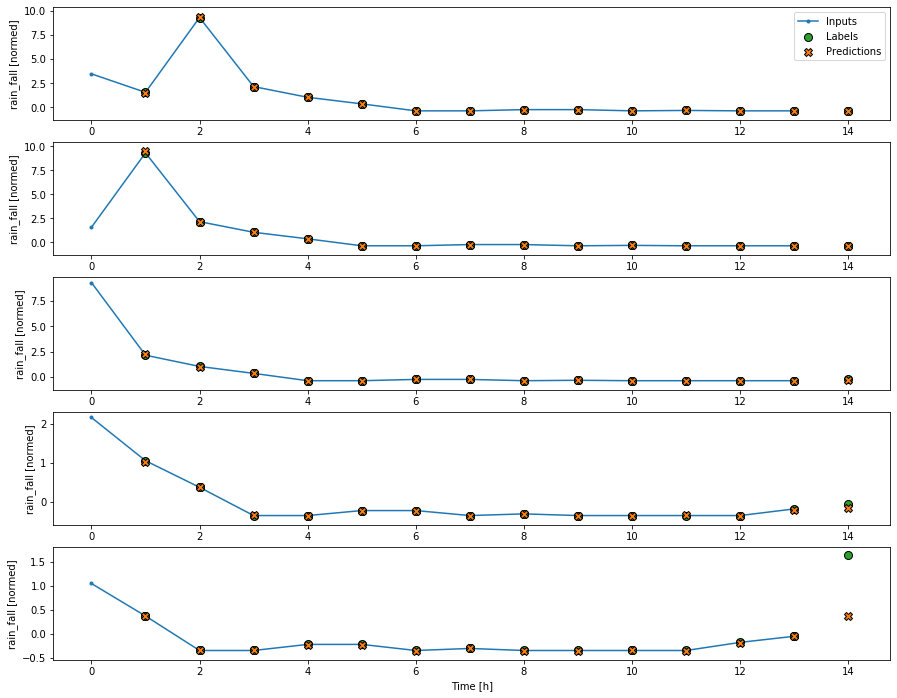

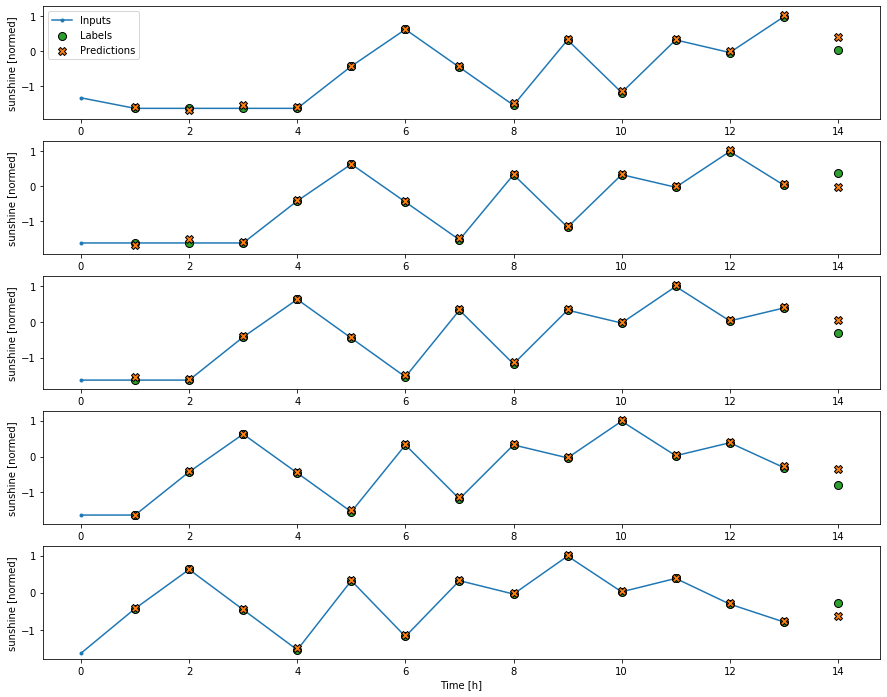

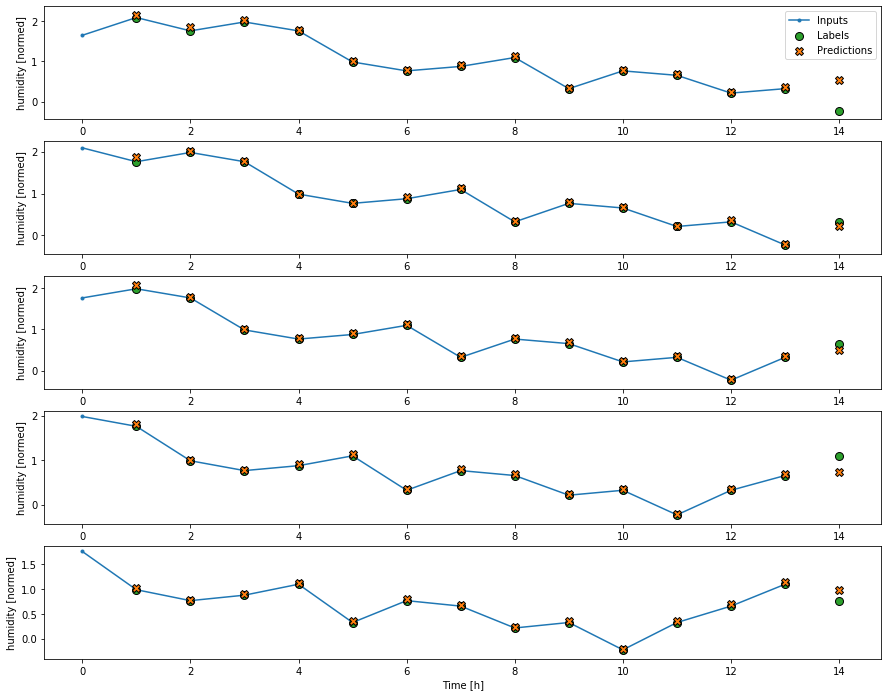

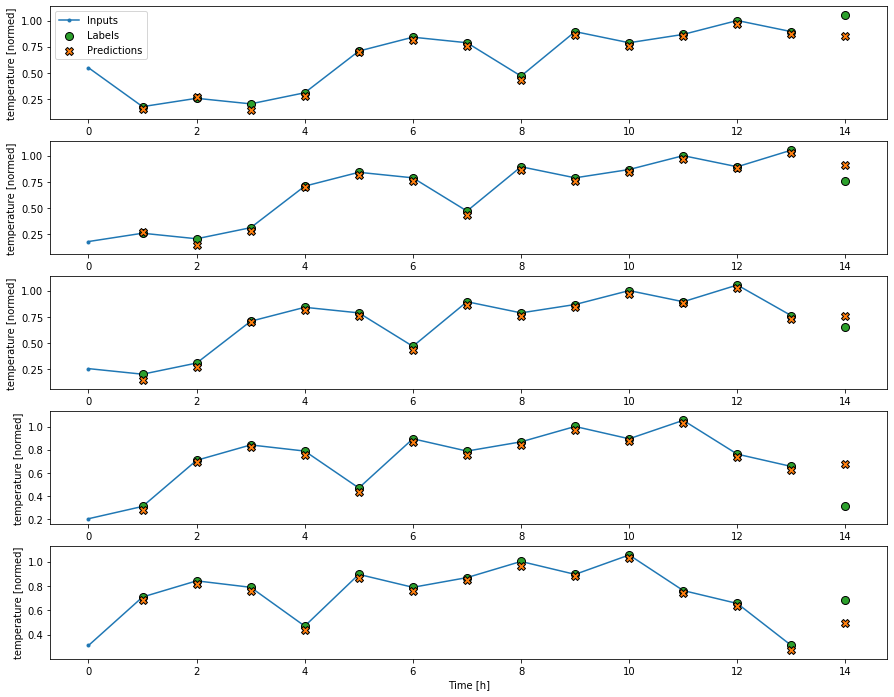

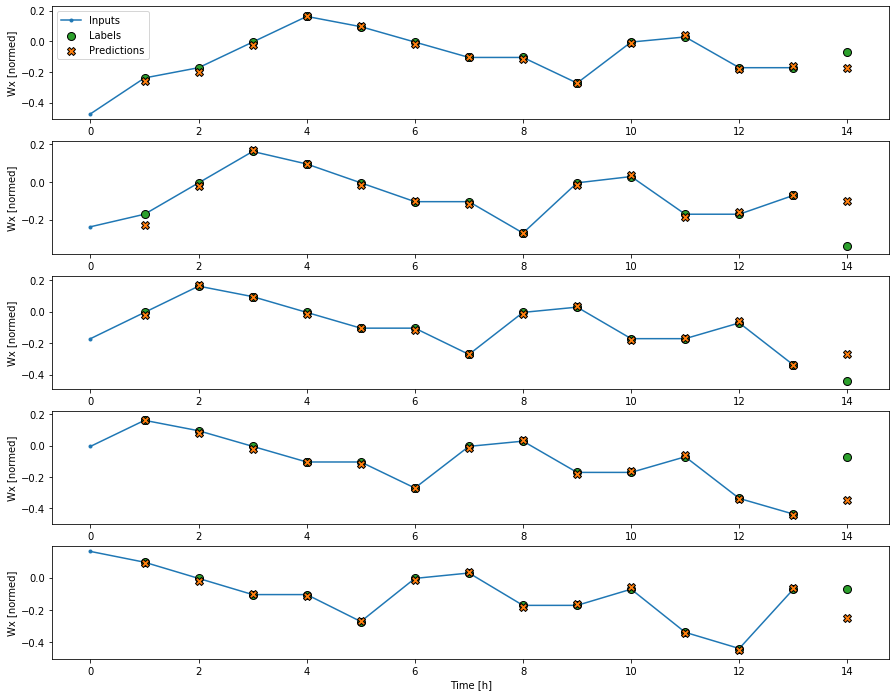

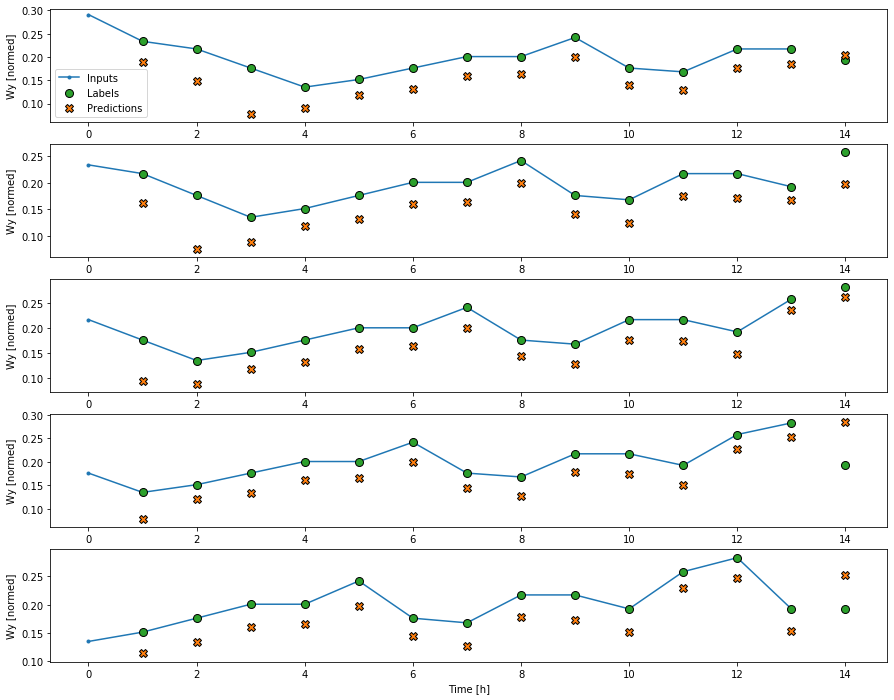

In [41]:
#wide_window_all = generate_window(dataset_city['dhaka'])
for x in y_col:
    wide_window_all.plot(bi_lstm_model_all_feature ,x ,max_subplots=5)

In [91]:

def print_perf_val_perf(perf , val_perf):
    print(f'{"model":50s}: Test   | Val')
    for i in range(len(metrics_name)):
        print("==================",metrics_name[i],"==================")
        for key in val_perf.keys():
            print(f'{str(key):50s}: {perf[key][i]:0.4f} | {val_perf[key][i]:0.4f}')


In [ ]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
f=open(ROOTPATH+"\\result\\"+dt_string+".txt",'w')
import sys
orig_stdout = sys.stdout
sys.stdout = f
print(bi_lstm_model_all_feature.summary())
print_perf_val_perf(performance_bi_lstm , val_performance_bi_lstm)
sys.stdout = orig_stdout
f.close()

dhaka ******************************


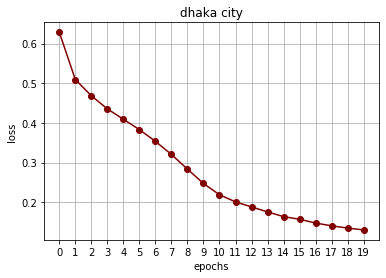

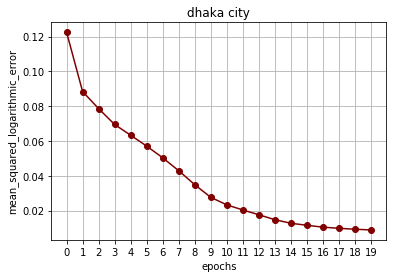

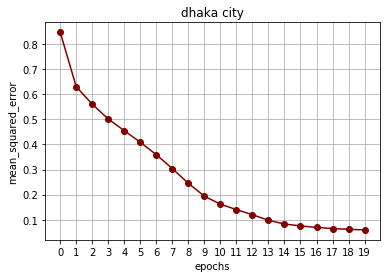

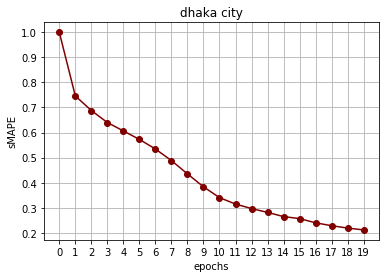

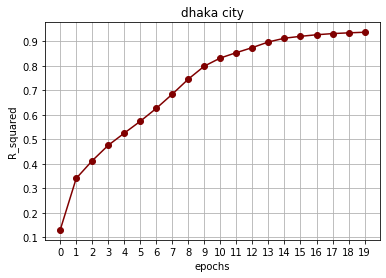

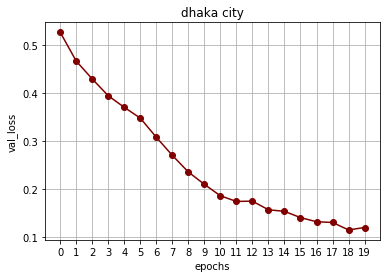

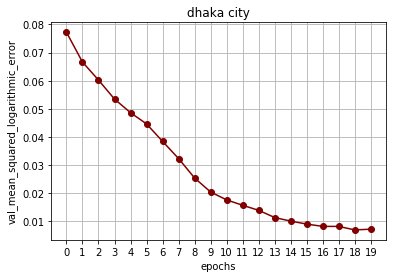

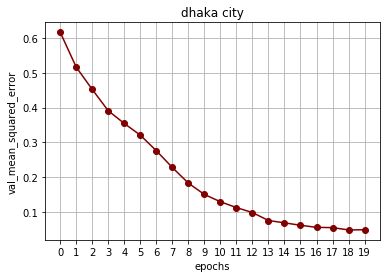

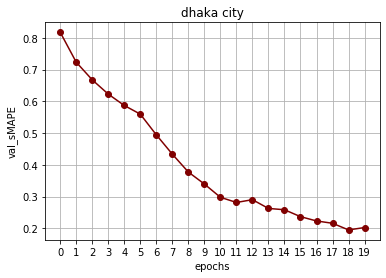

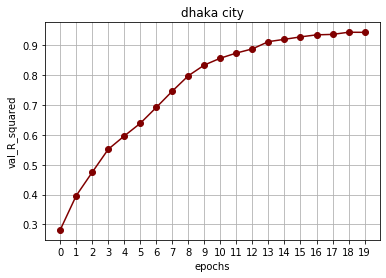

tangail ******************************


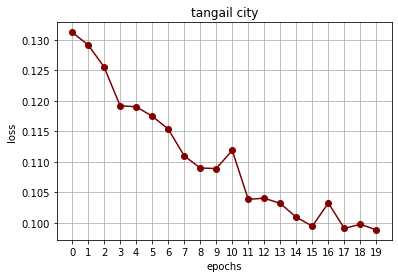

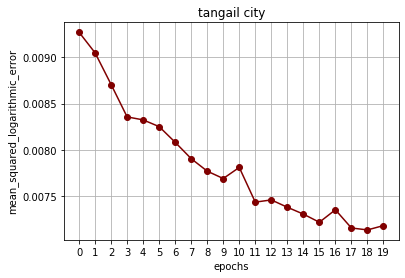

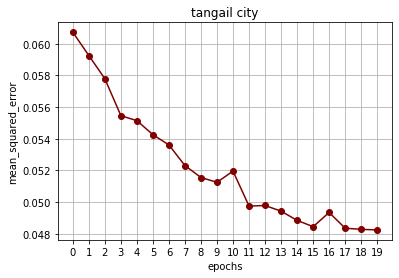

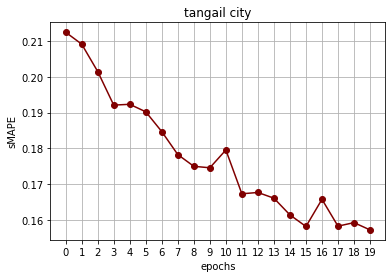

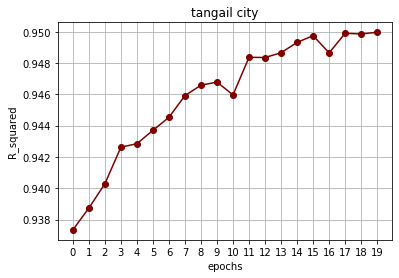

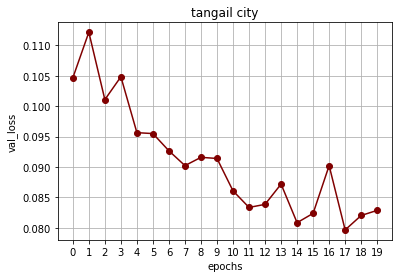

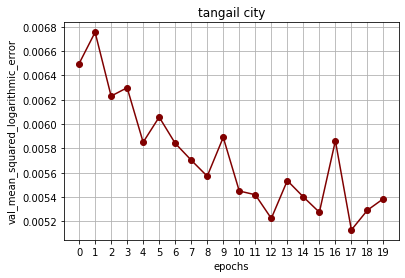

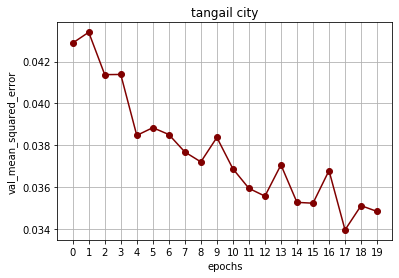

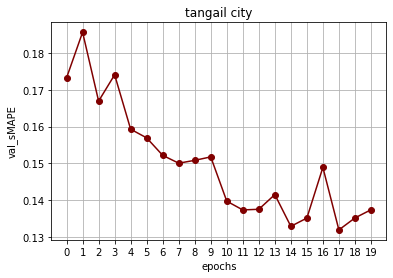

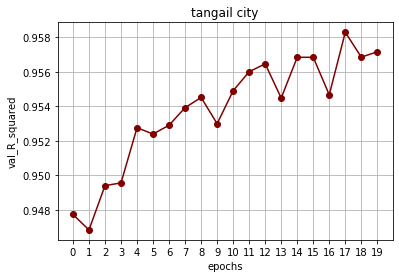

mymensingh ******************************


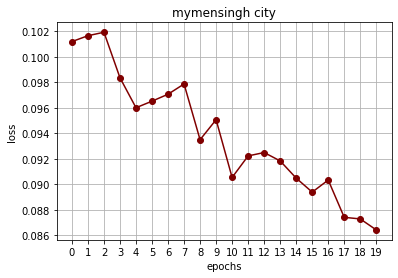

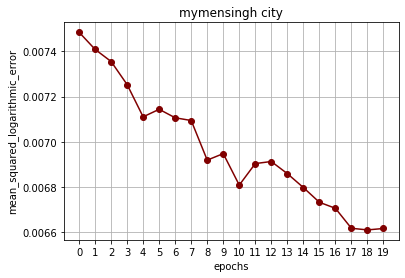

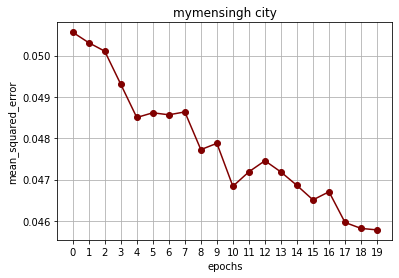

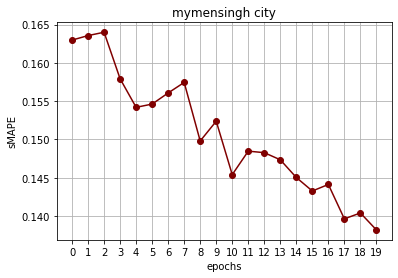

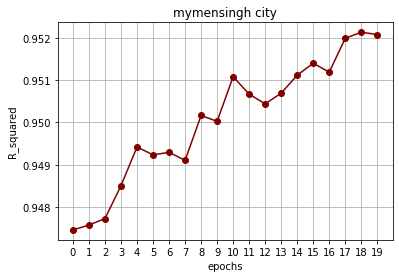

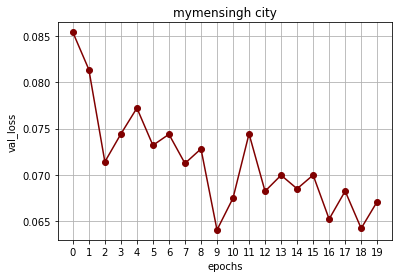

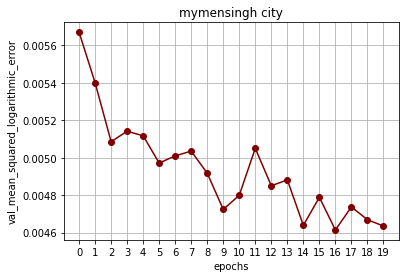

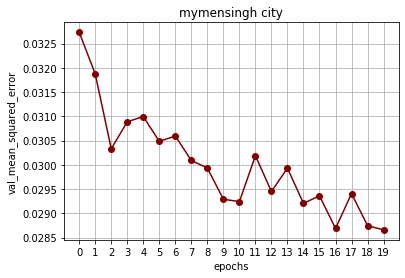

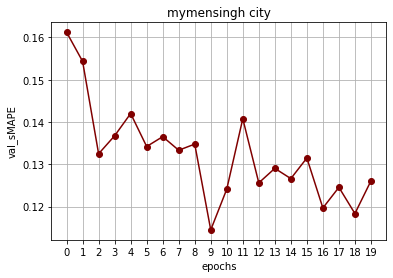

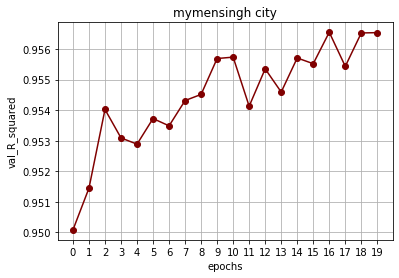

faridpur ******************************


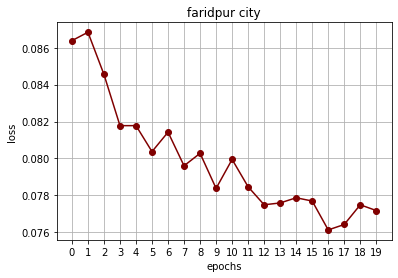

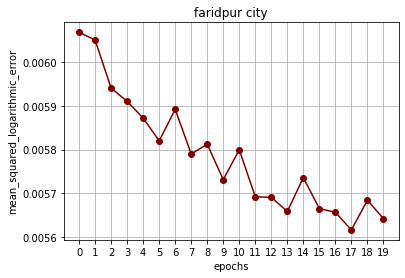

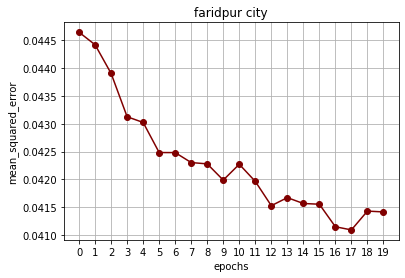

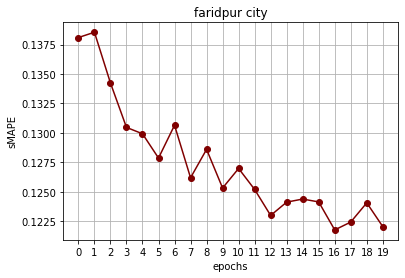

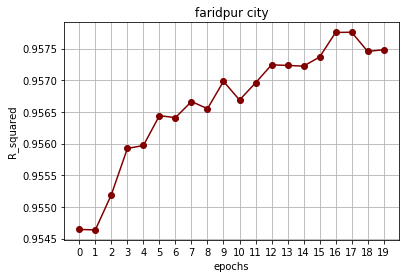

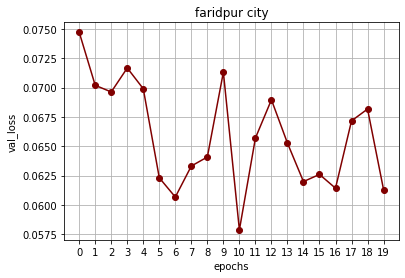

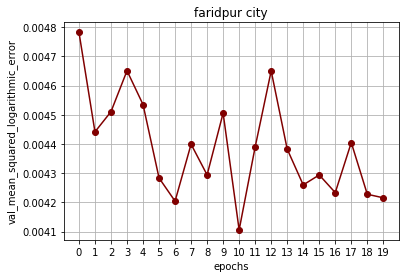

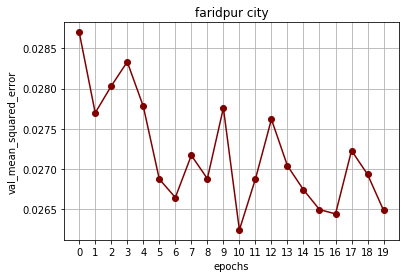

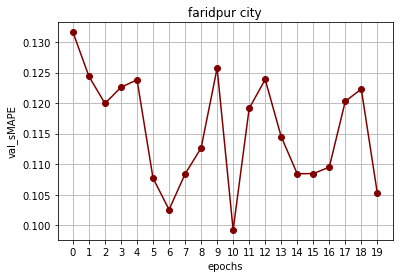

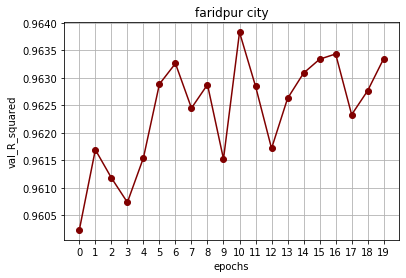

madaripur ******************************


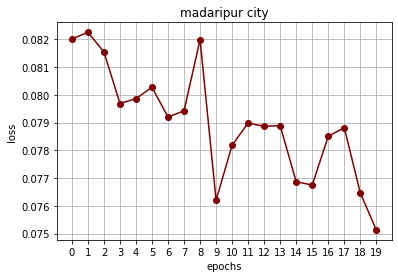

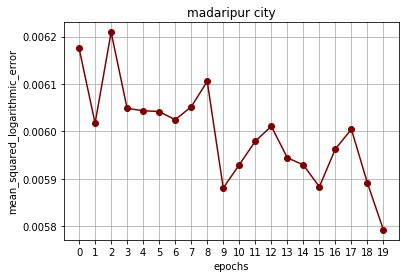

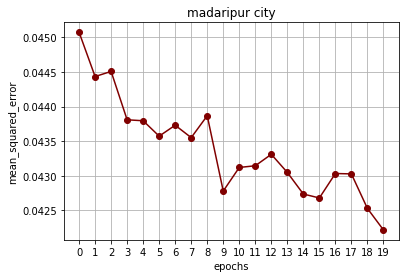

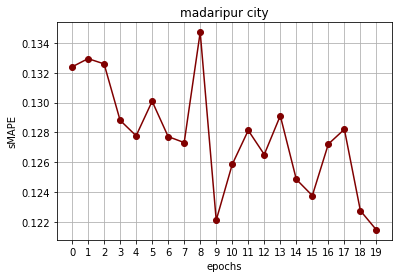

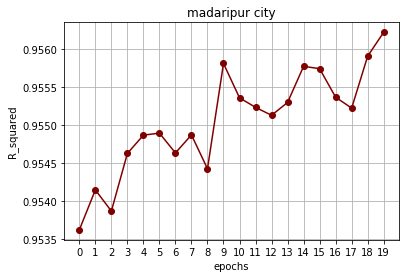

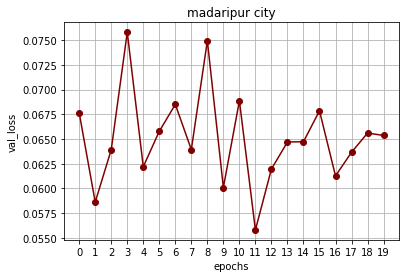

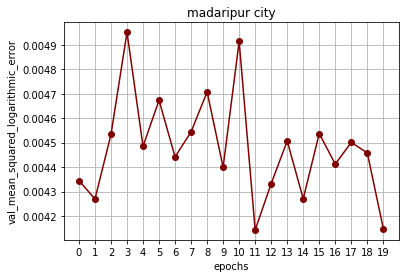

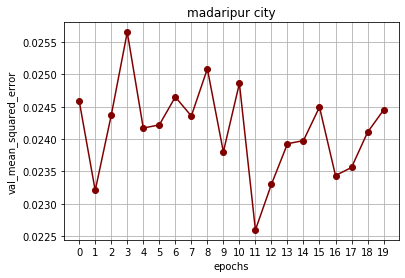

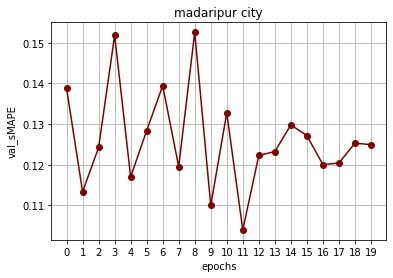

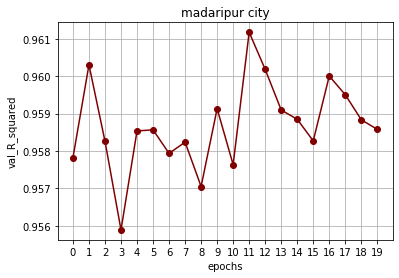

srimangal ******************************


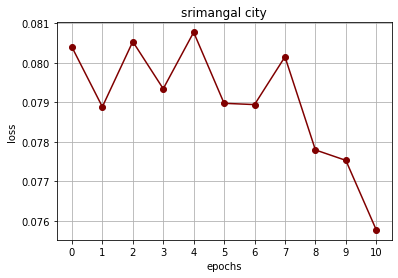

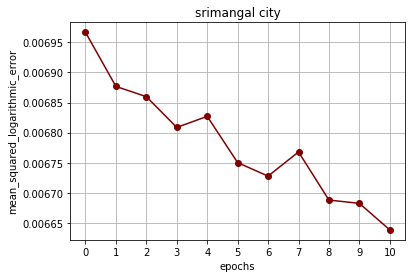

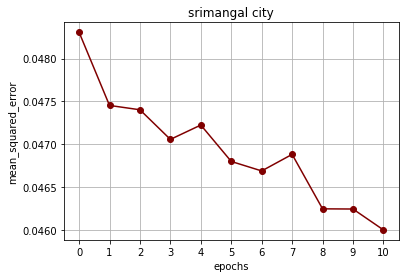

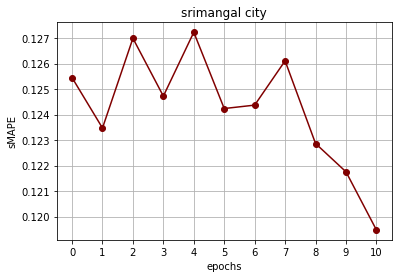

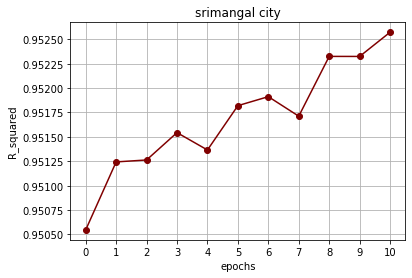

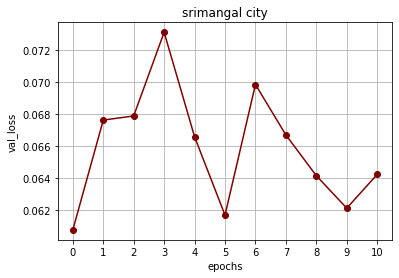

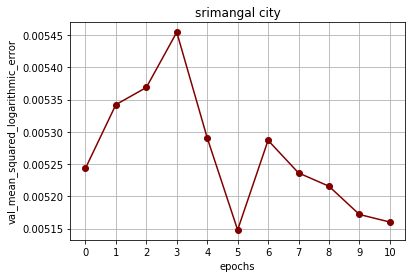

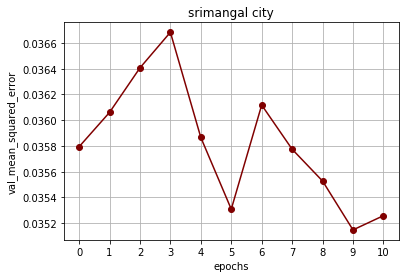

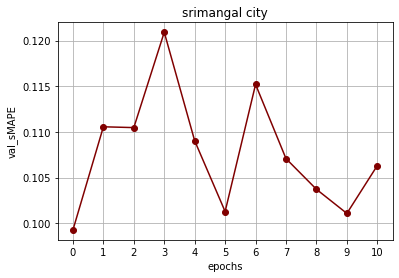

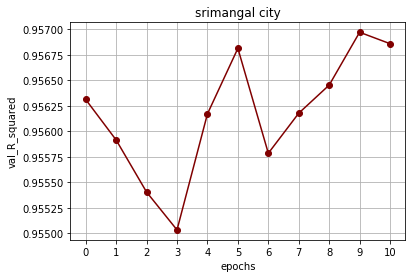

sylhet ******************************


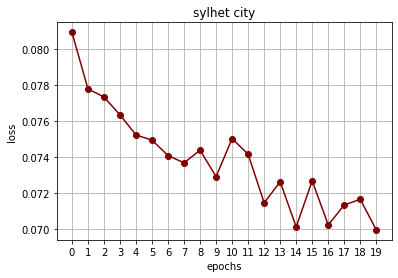

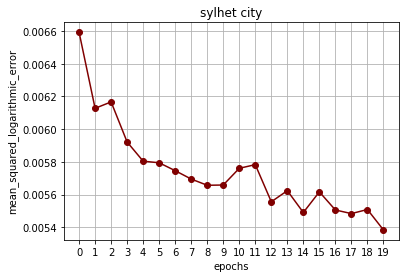

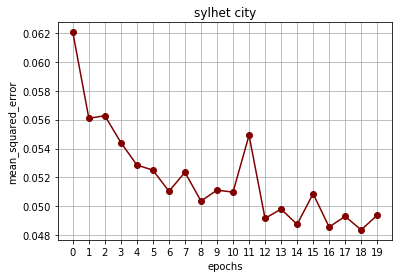

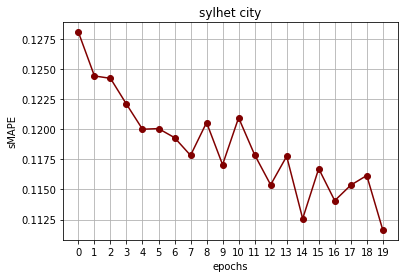

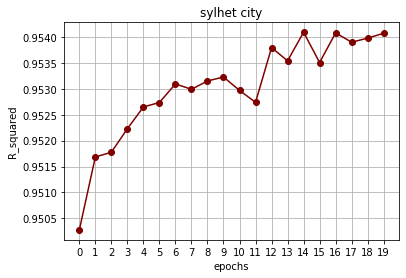

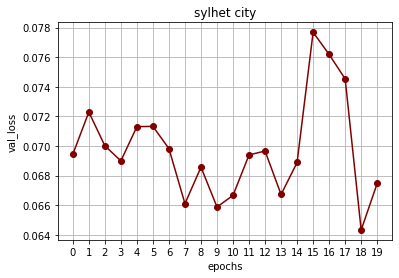

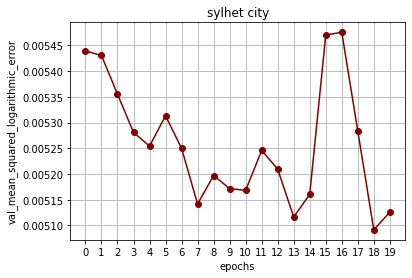

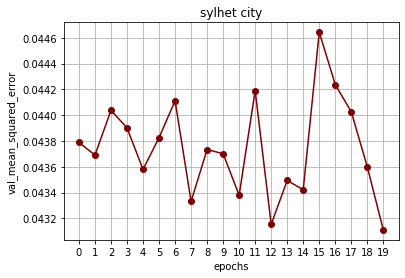

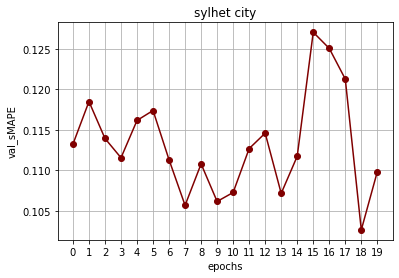

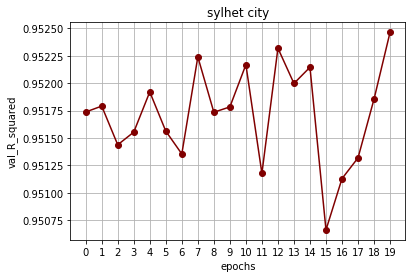

bogra ******************************


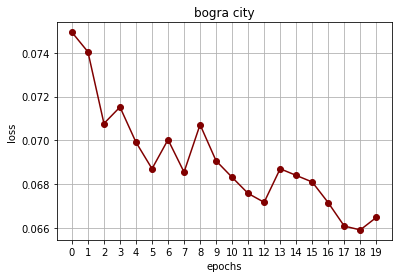

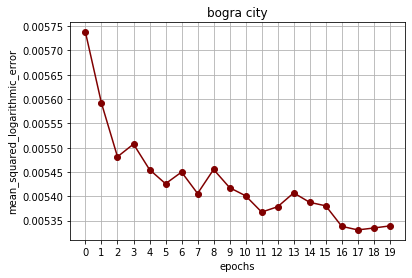

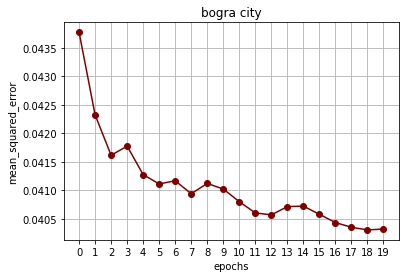

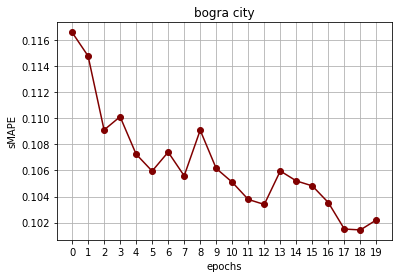

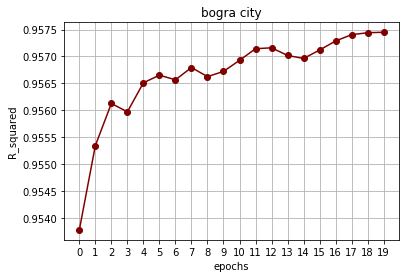

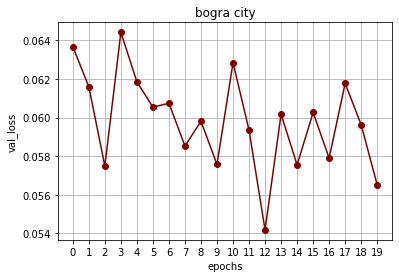

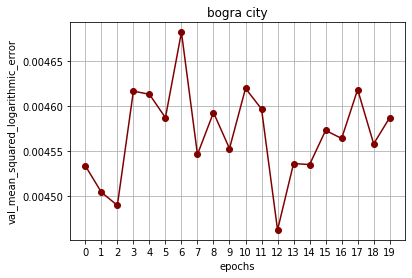

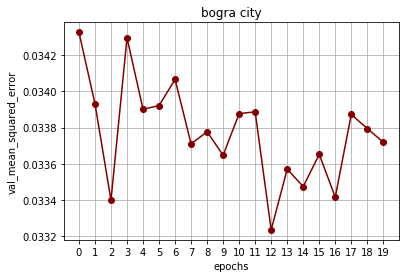

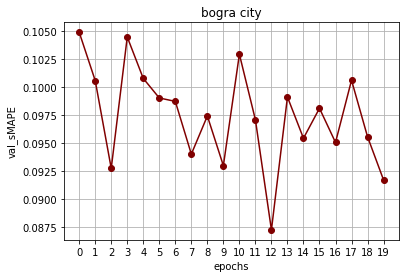

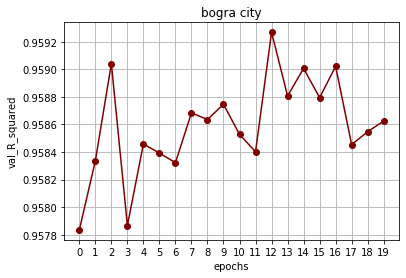

dinajpur ******************************


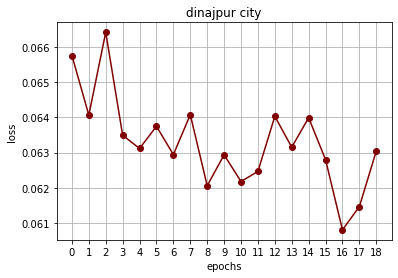

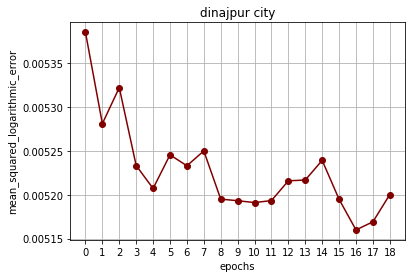

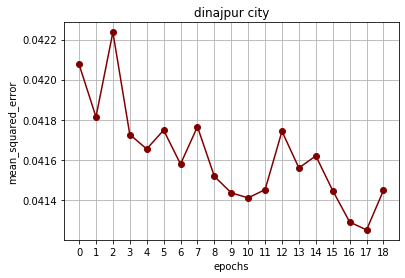

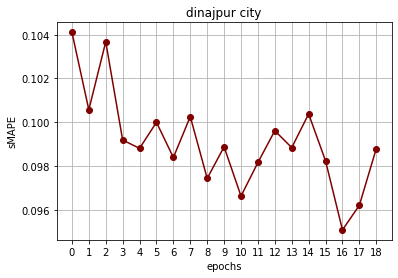

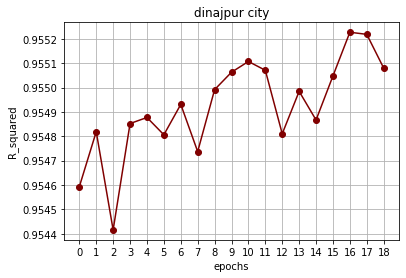

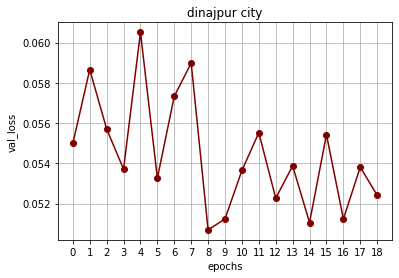

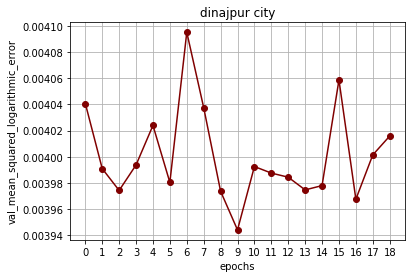

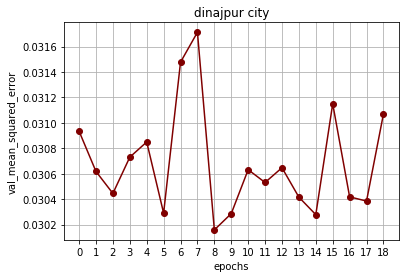

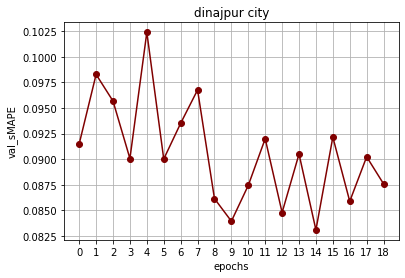

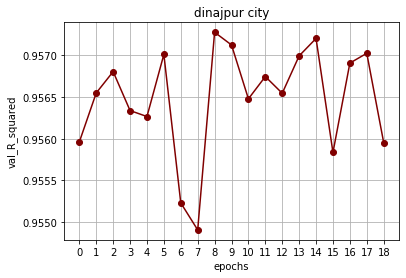

ishurdi ******************************


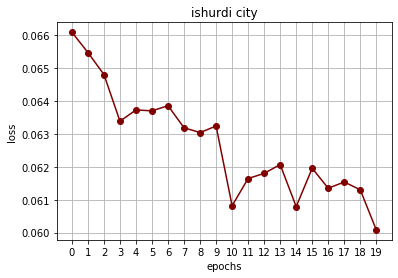

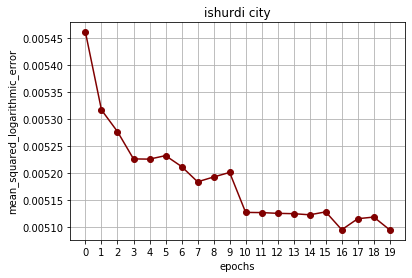

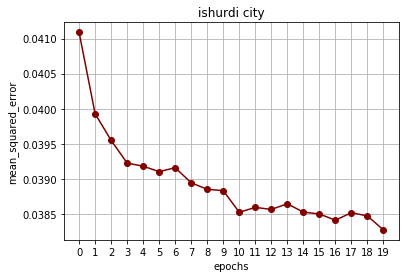

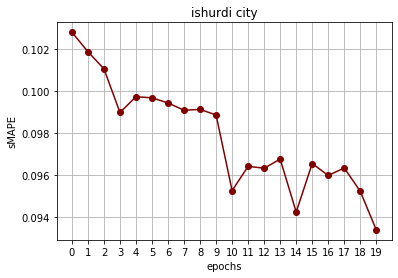

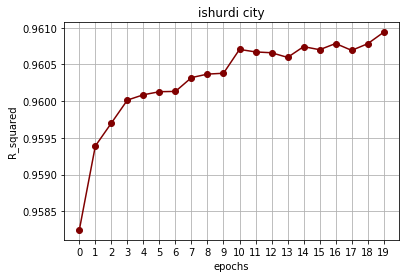

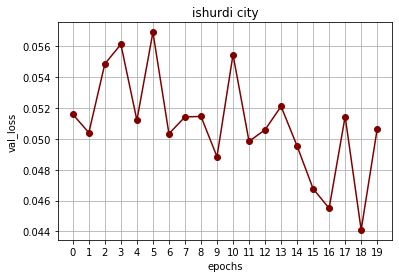

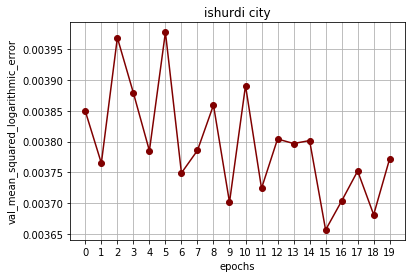

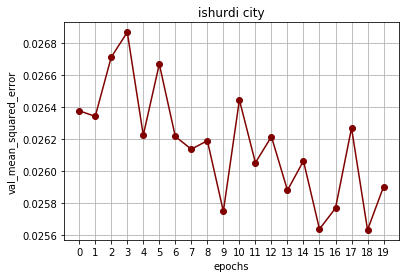

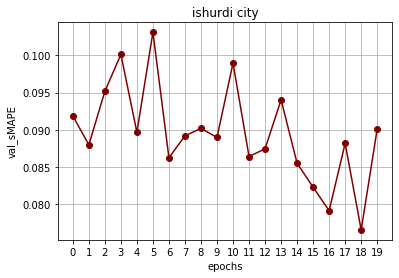

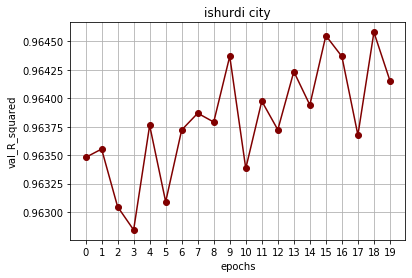

rajshahi ******************************


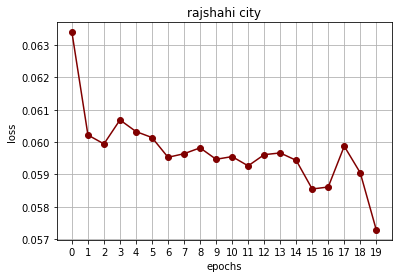

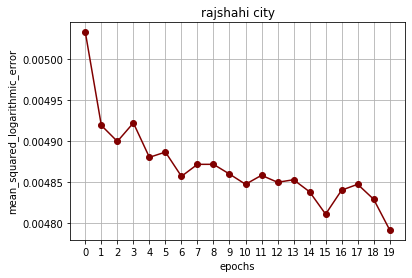

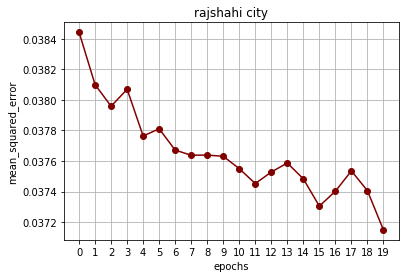

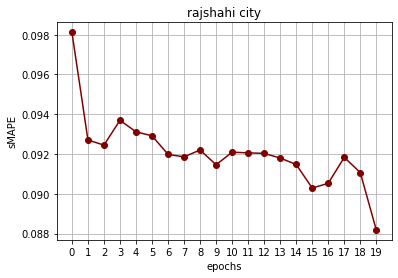

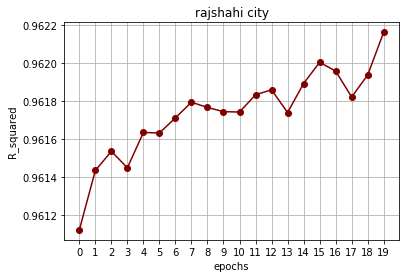

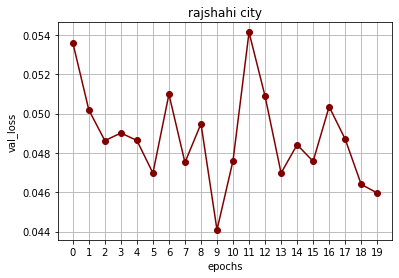

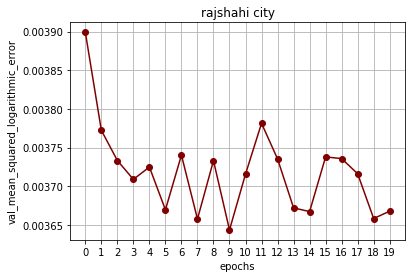

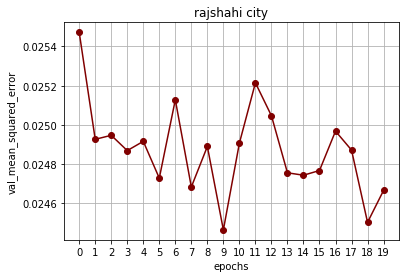

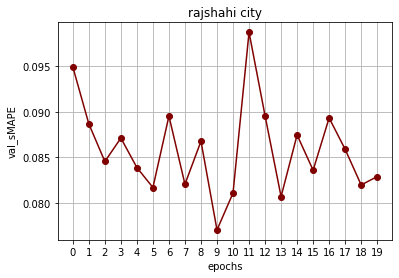

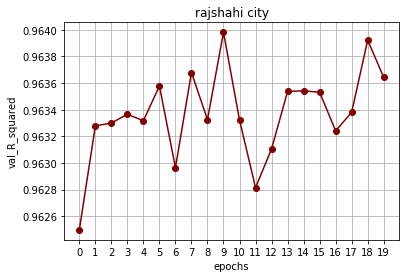

rangpur ******************************


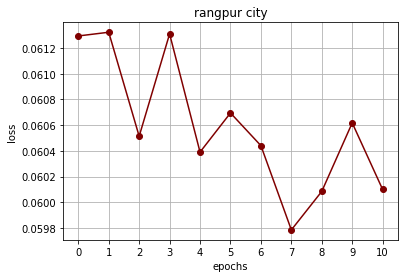

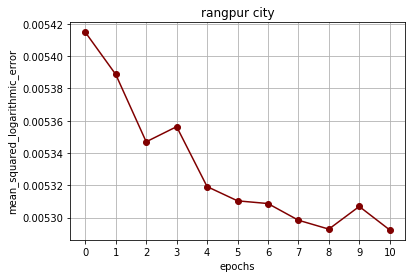

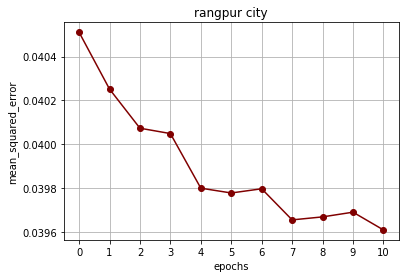

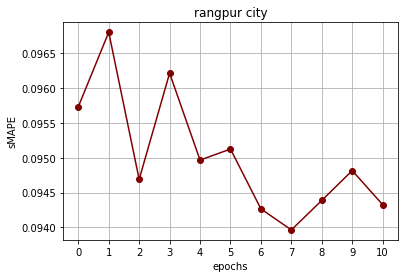

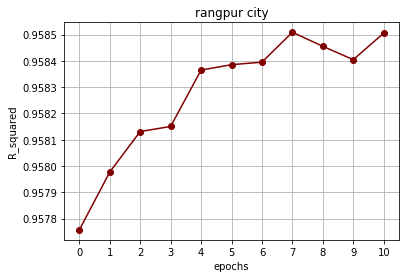

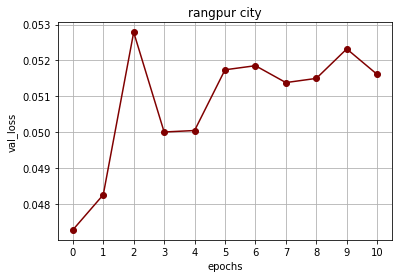

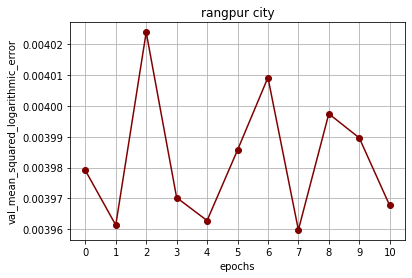

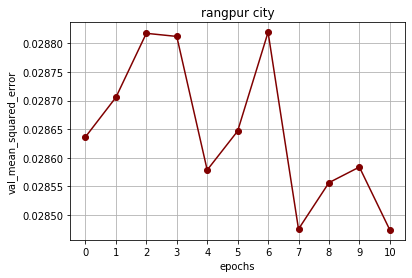

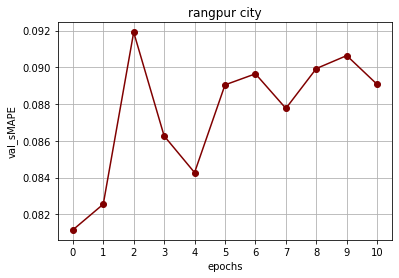

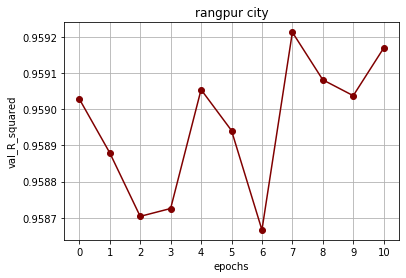

sydpur ******************************


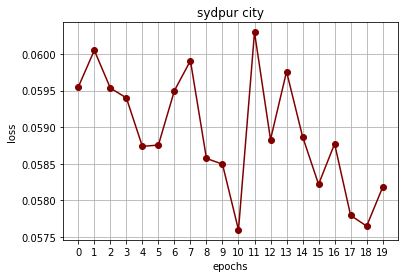

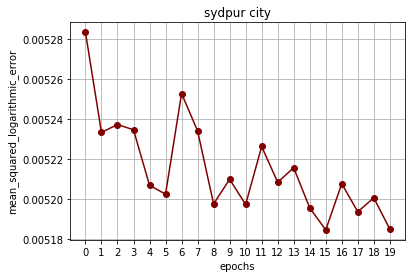

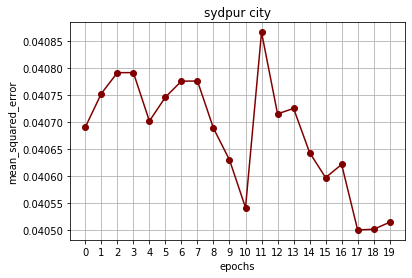

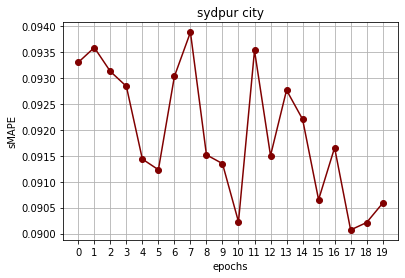

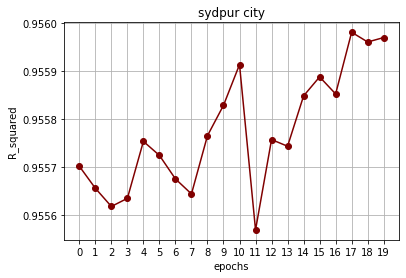

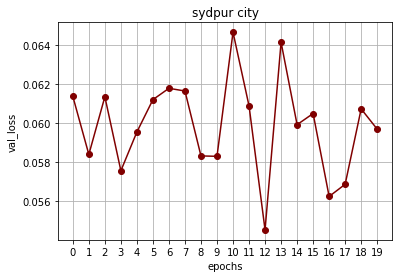

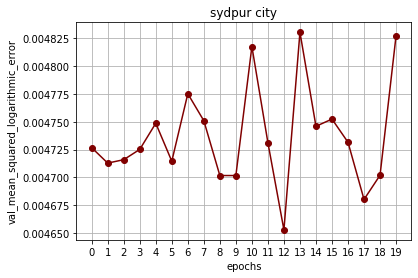

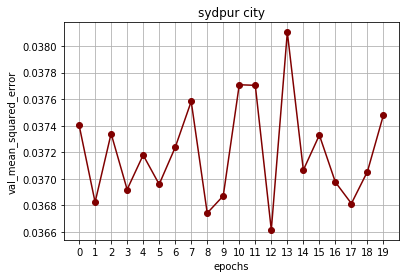

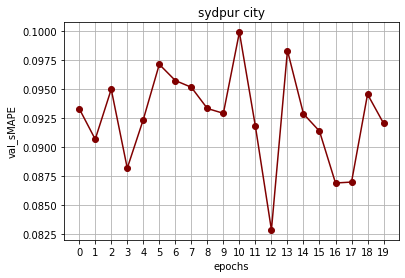

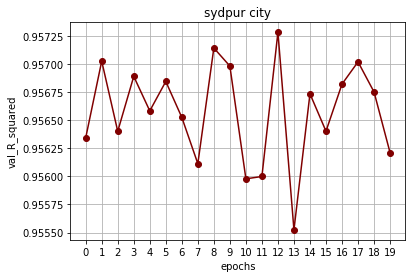

chuadanga ******************************


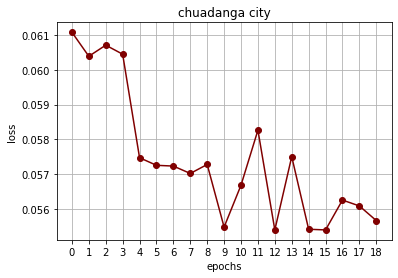

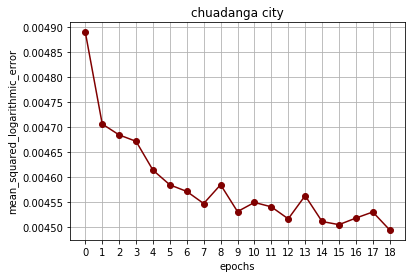

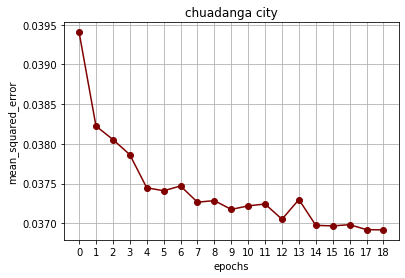

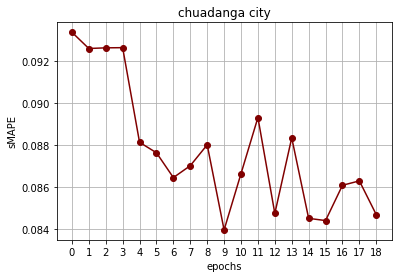

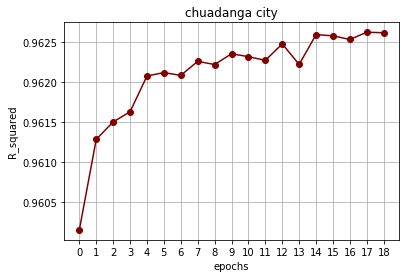

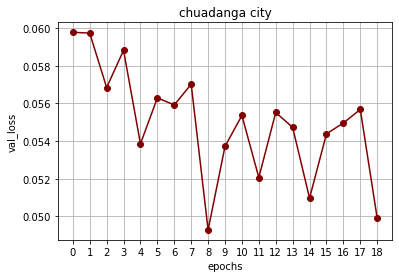

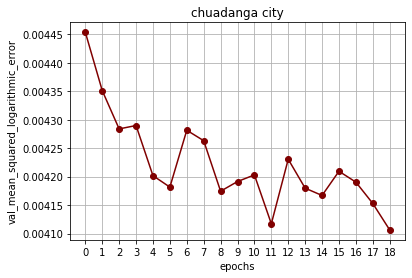

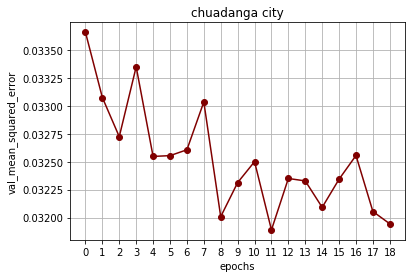

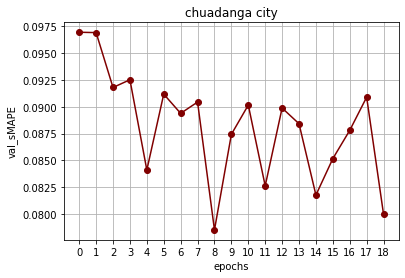

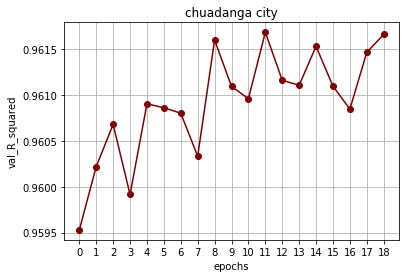

jessore ******************************


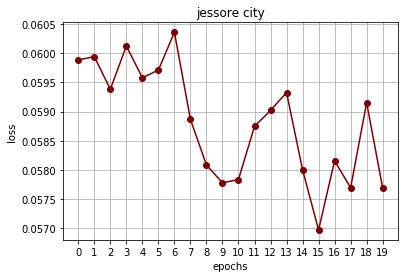

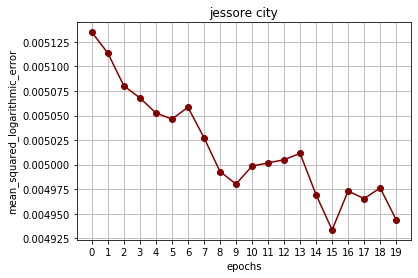

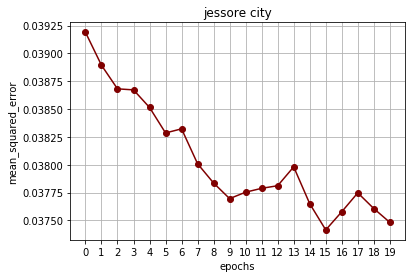

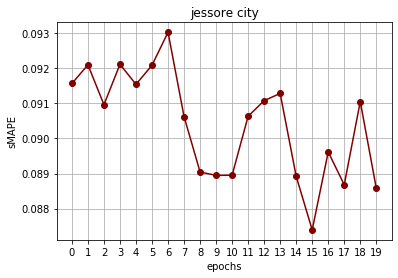

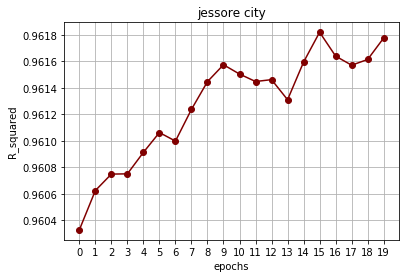

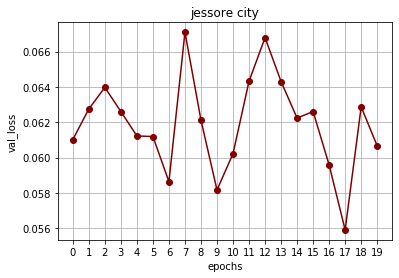

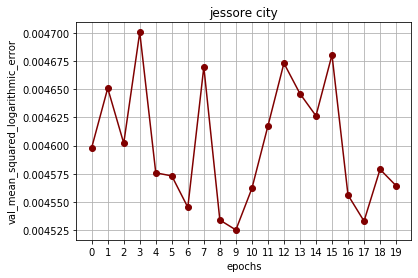

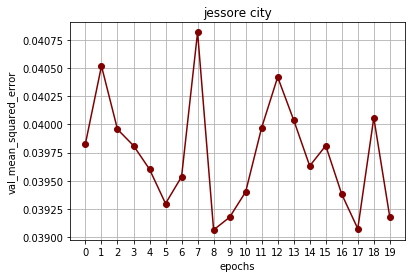

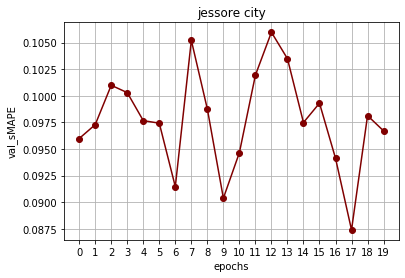

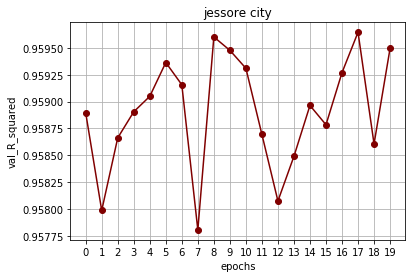

khulna ******************************


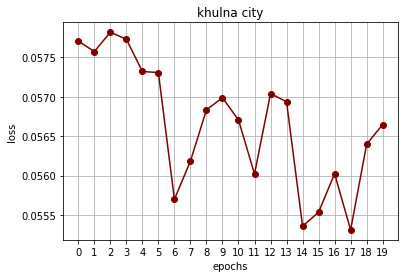

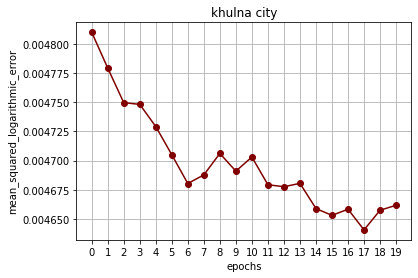

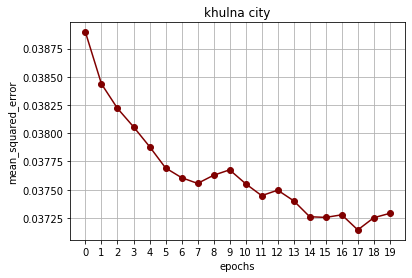

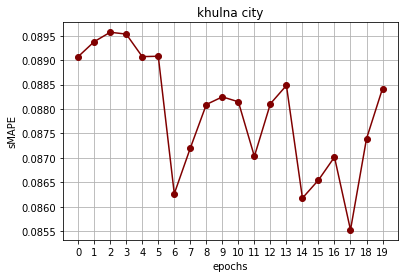

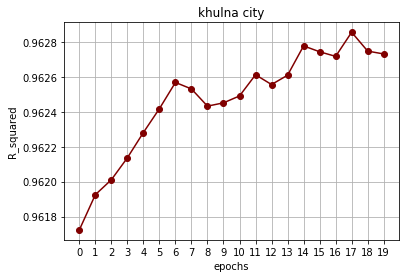

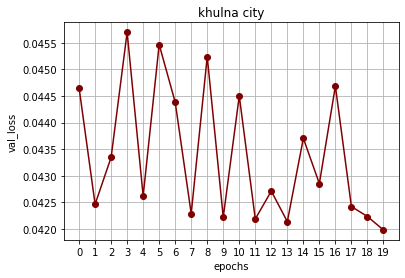

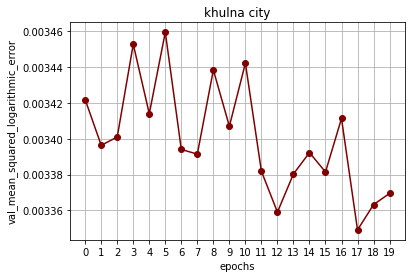

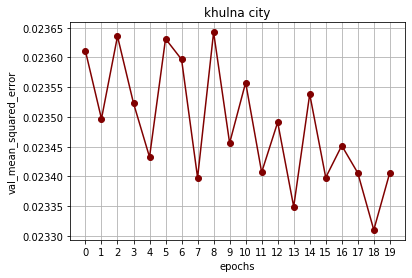

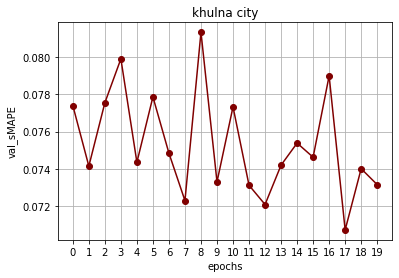

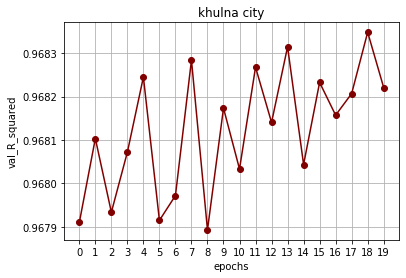

mongla ******************************


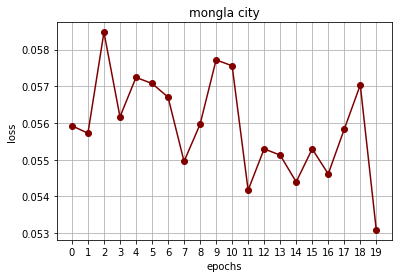

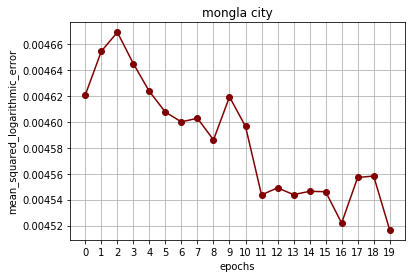

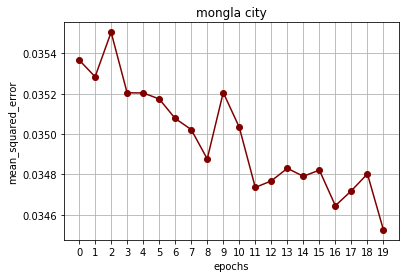

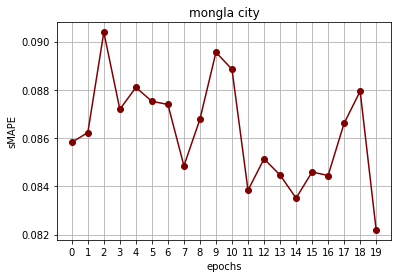

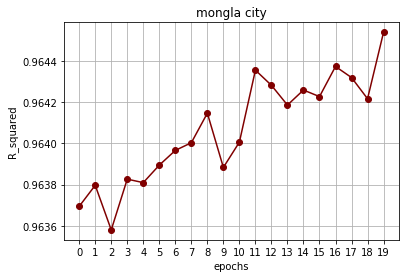

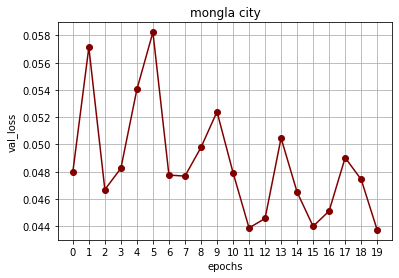

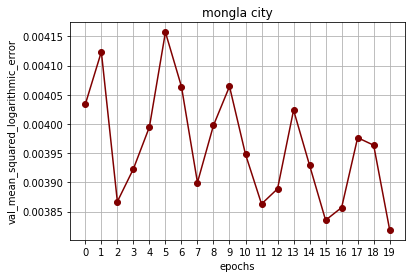

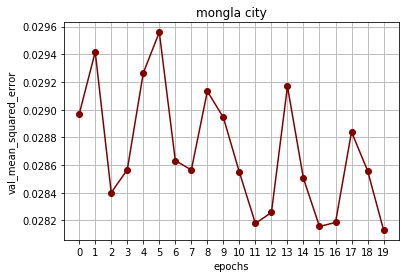

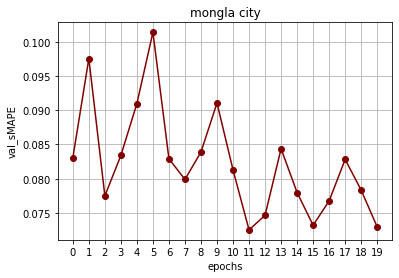

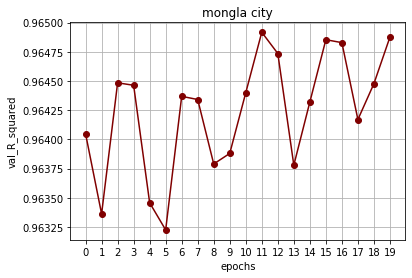

satkhira ******************************


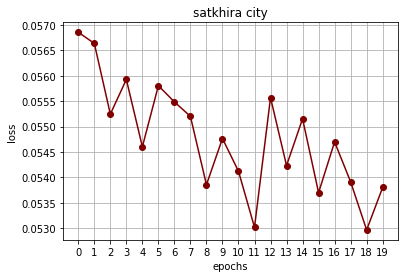

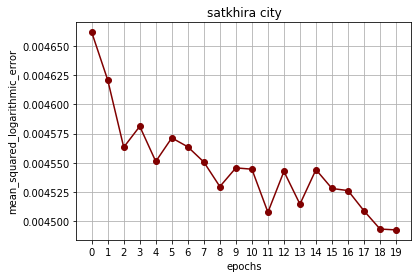

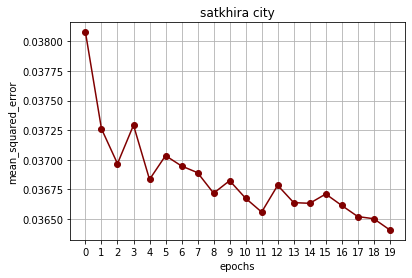

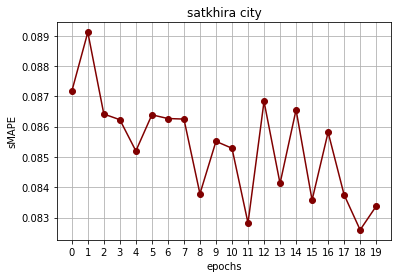

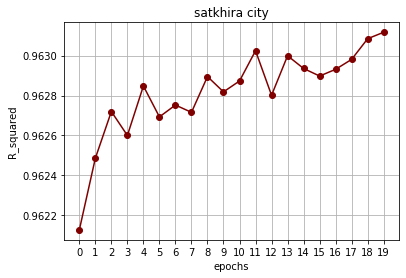

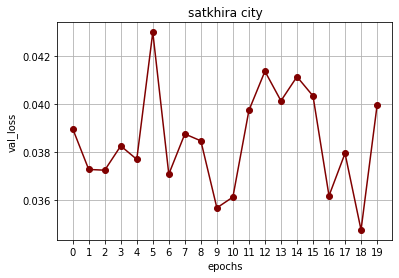

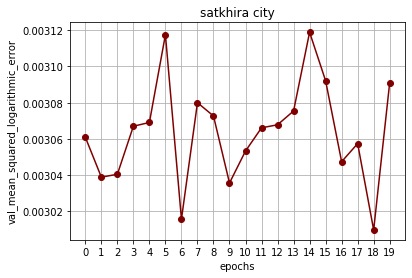

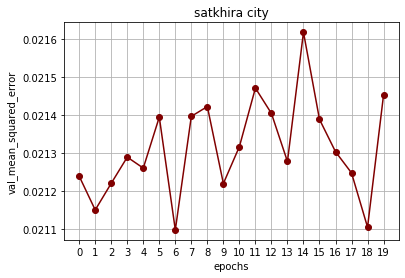

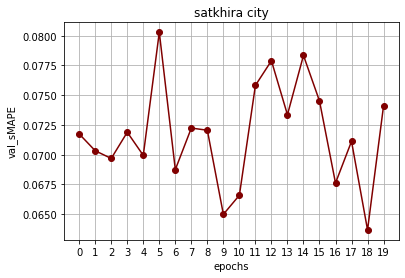

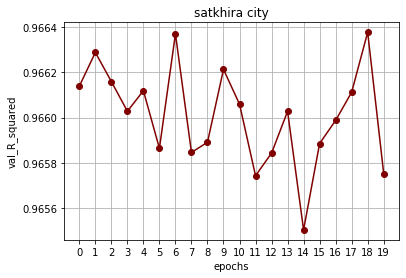

barisal ******************************


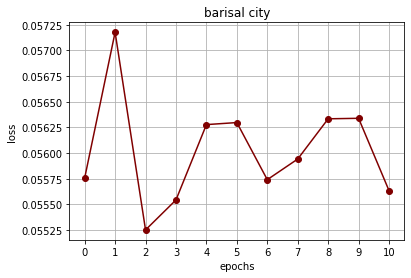

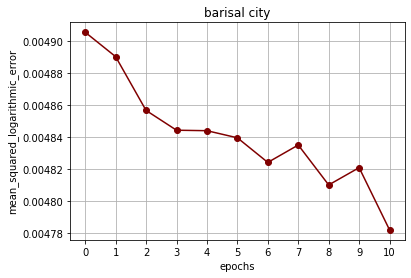

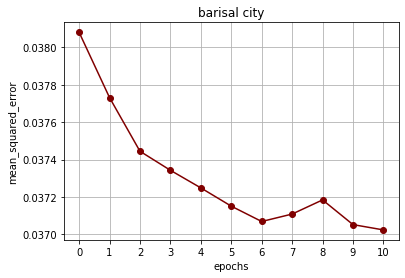

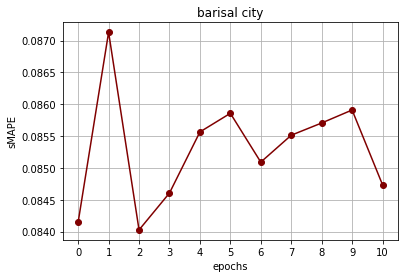

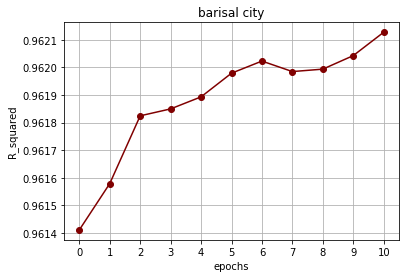

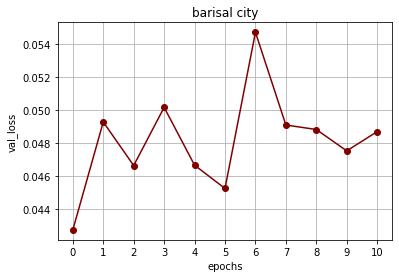

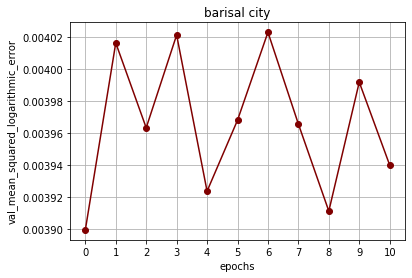

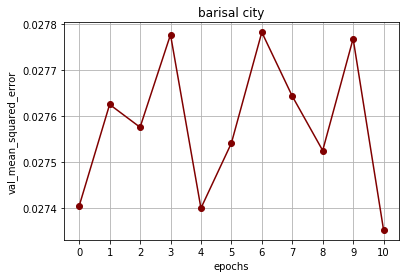

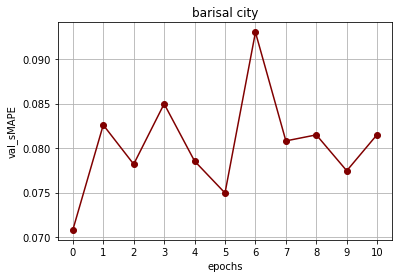

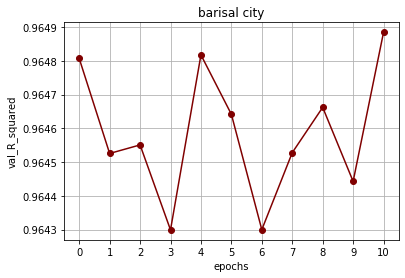

bhola ******************************


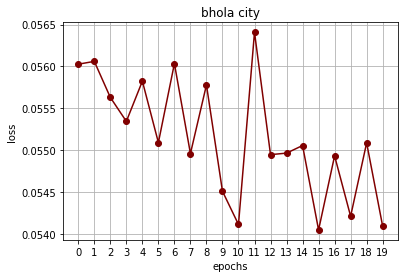

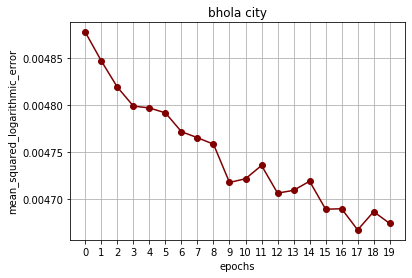

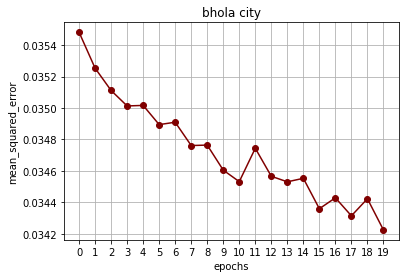

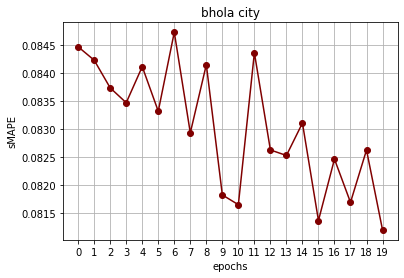

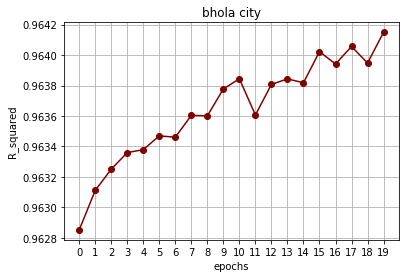

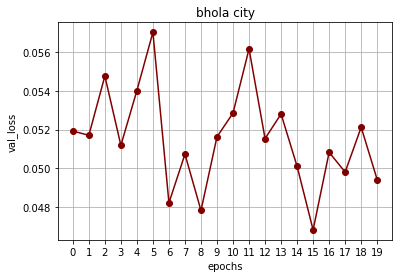

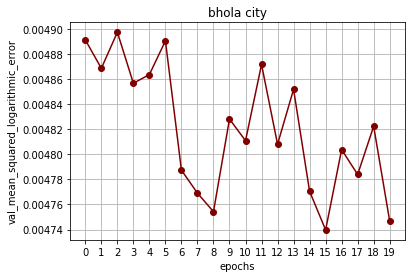

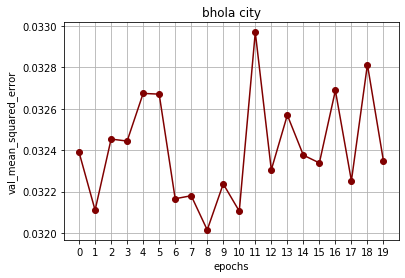

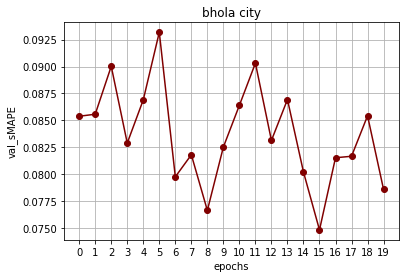

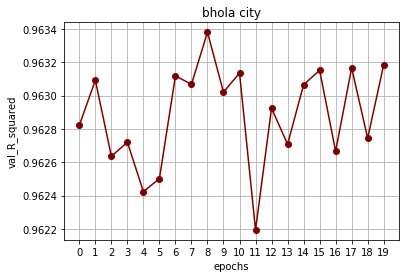

khepupara ******************************


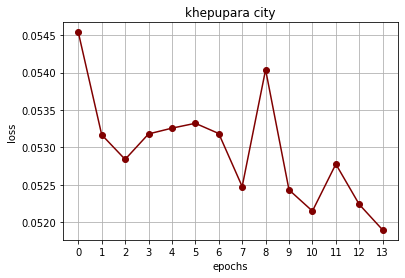

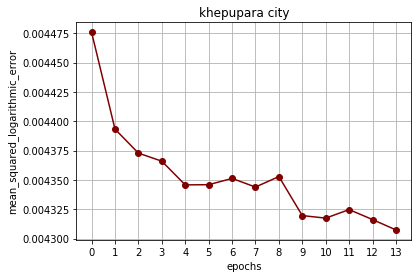

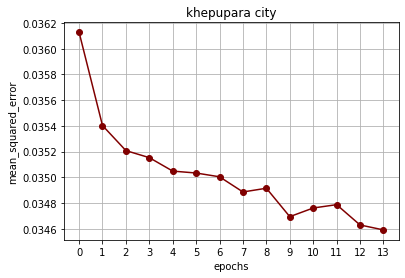

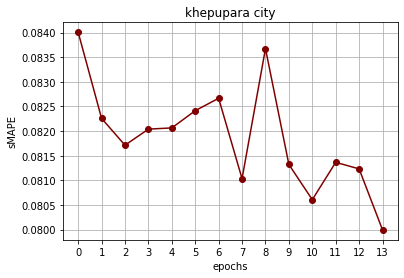

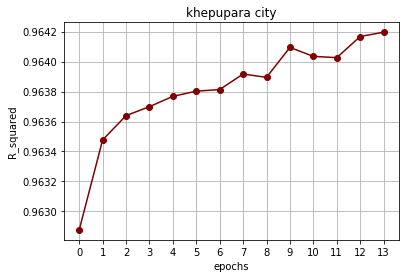

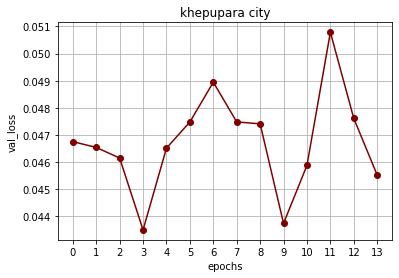

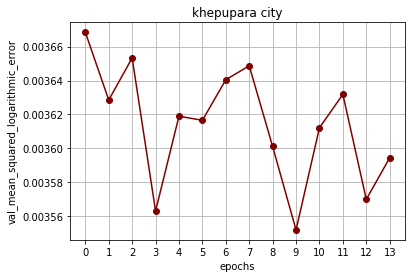

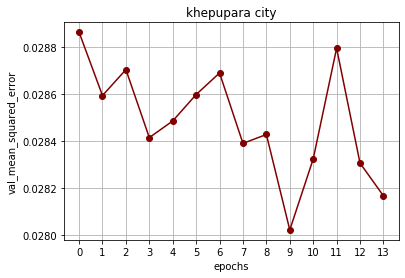

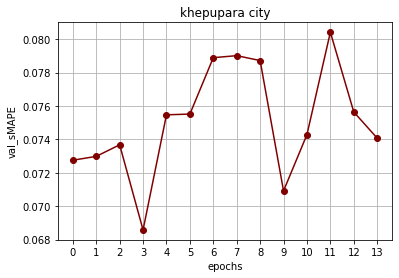

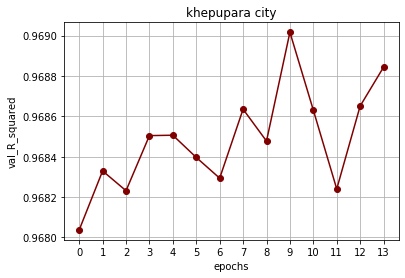

patuakhali ******************************


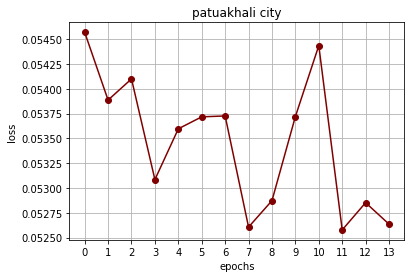

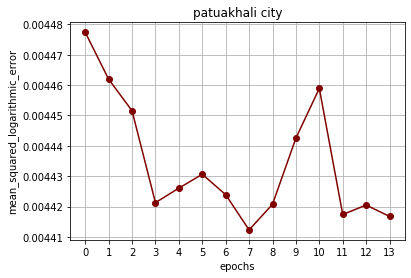

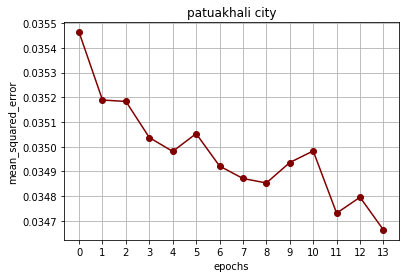

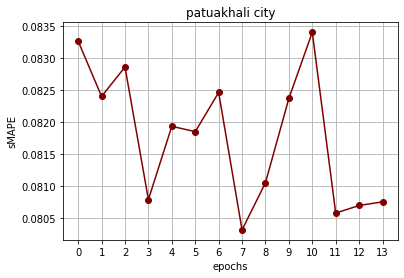

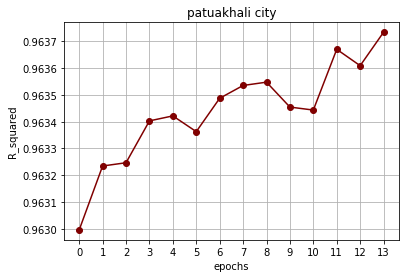

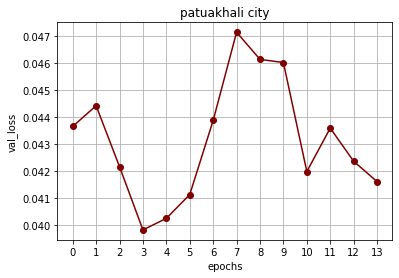

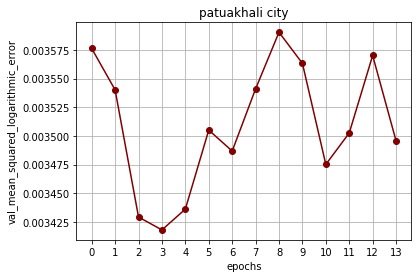

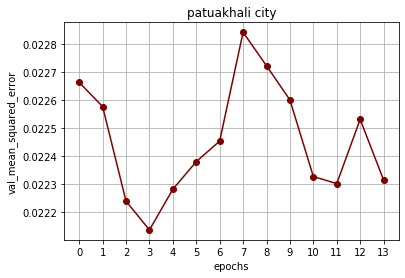

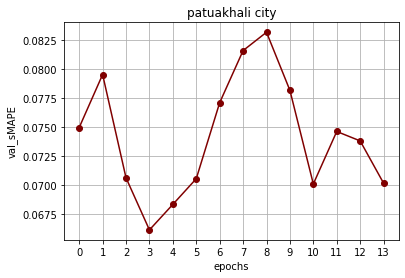

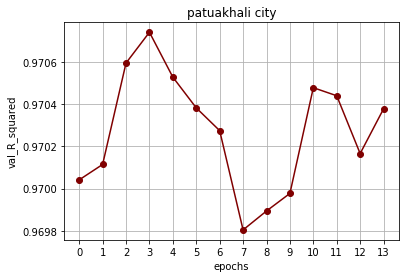

chandpur ******************************


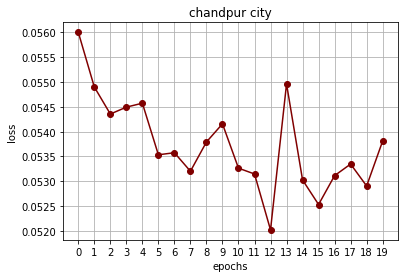

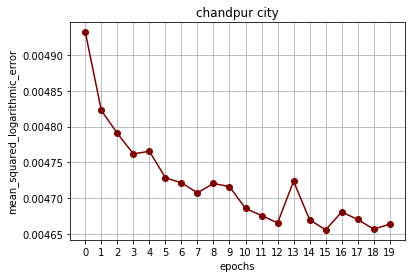

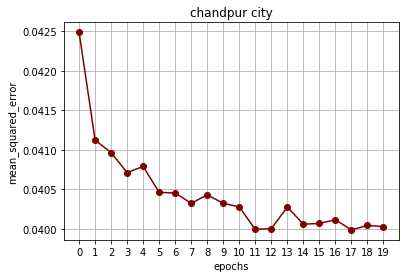

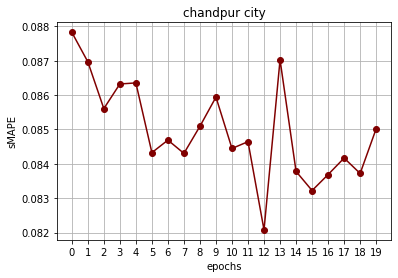

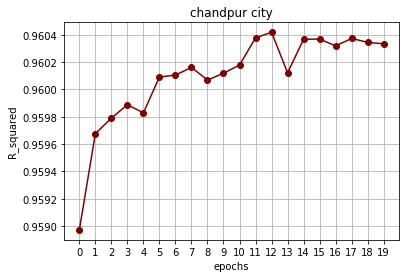

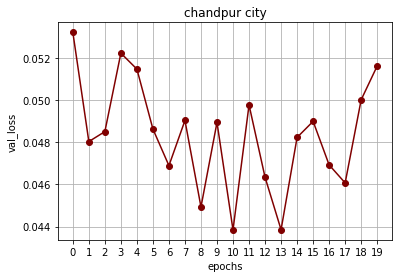

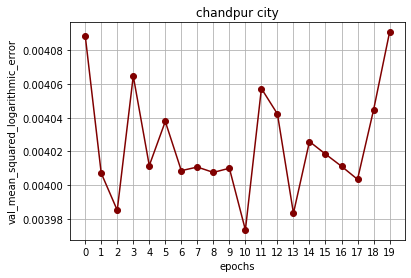

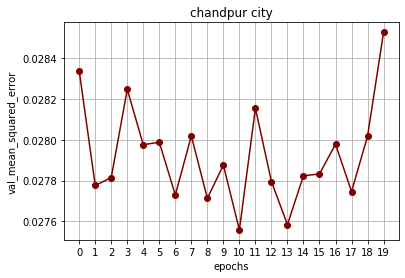

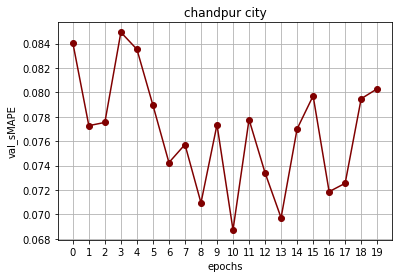

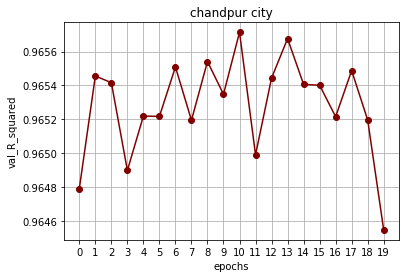

teknaf ******************************


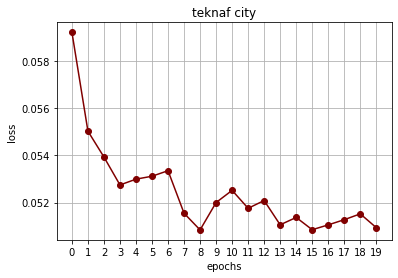

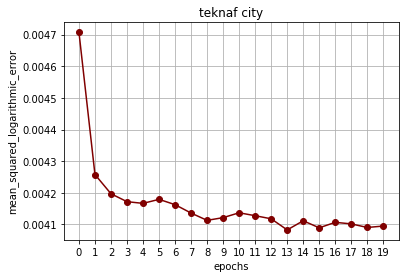

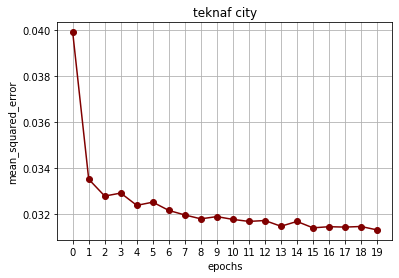

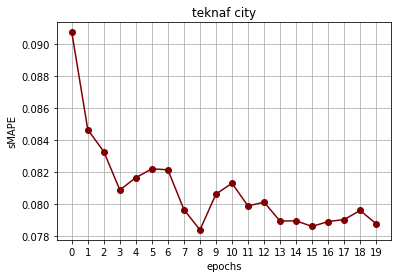

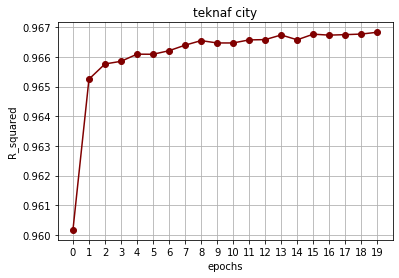

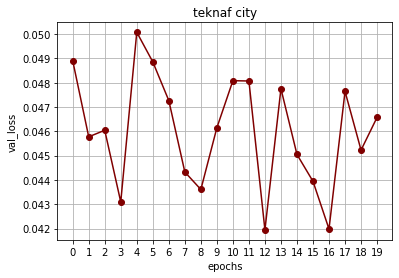

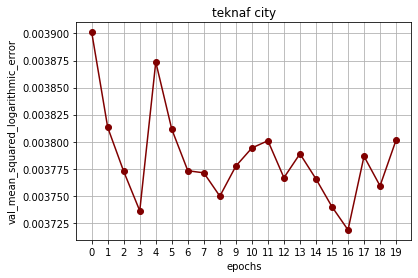

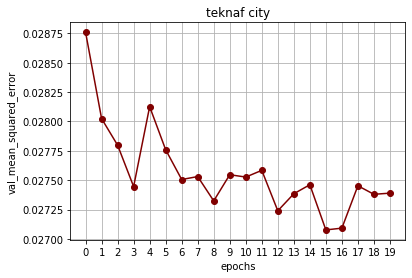

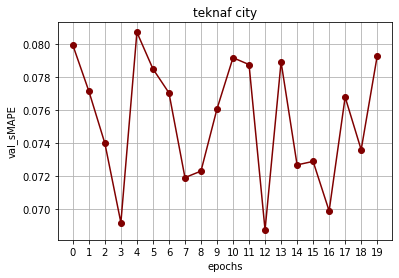

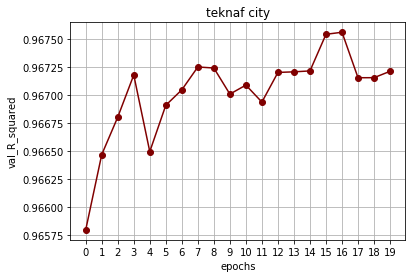

chittagong ******************************


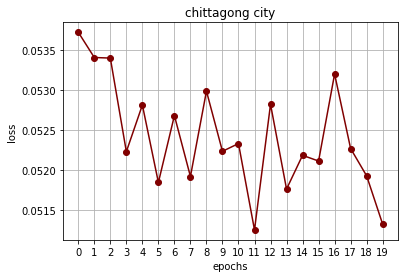

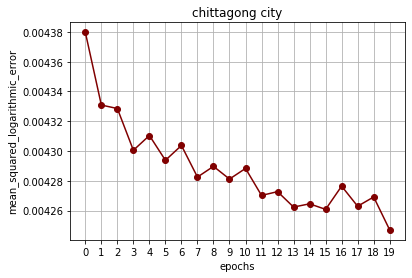

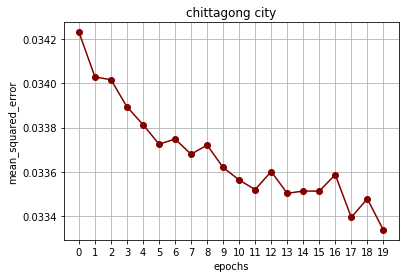

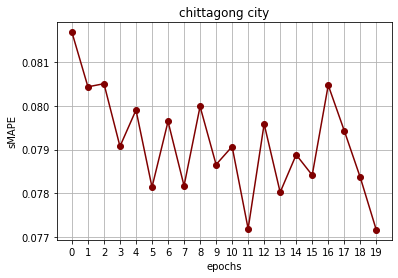

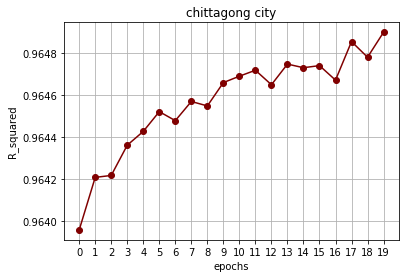

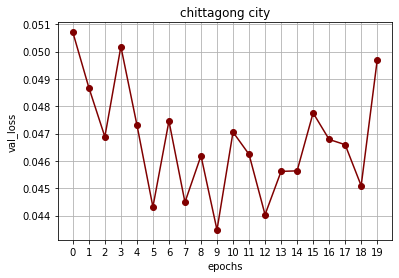

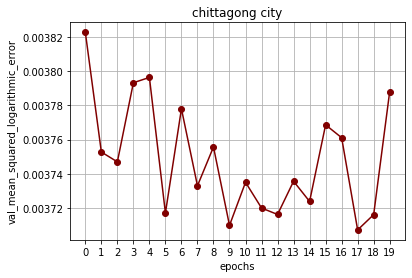

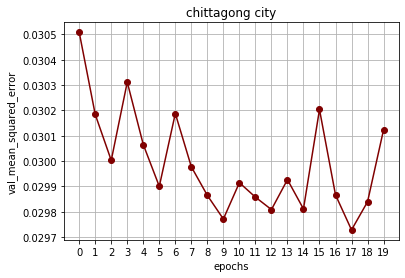

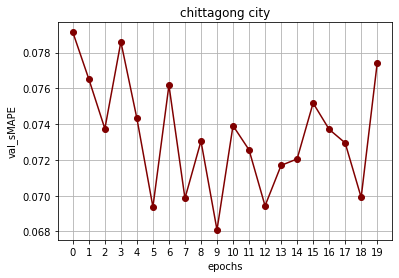

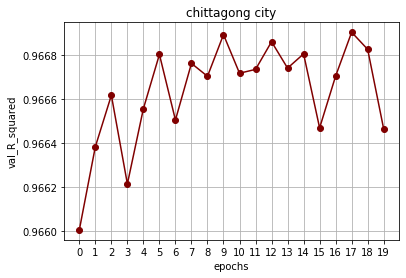

comilla ******************************


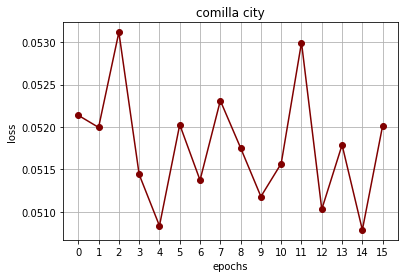

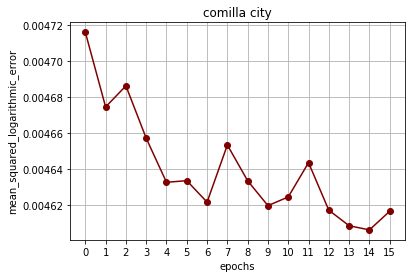

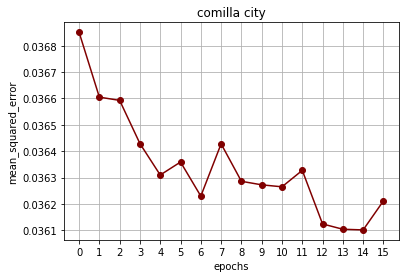

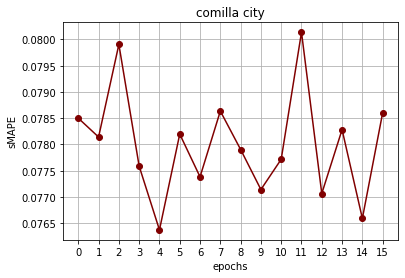

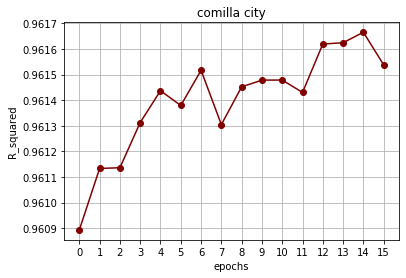

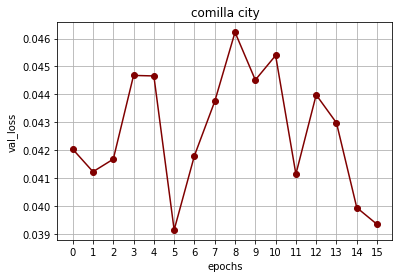

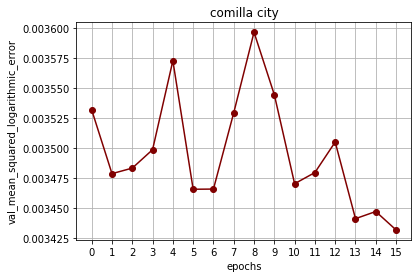

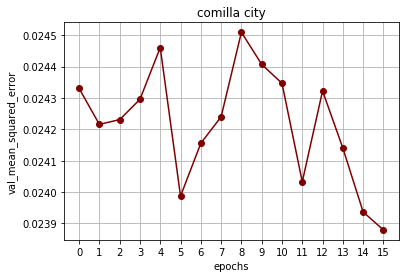

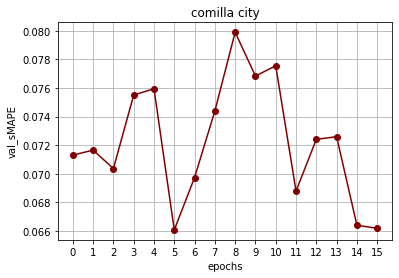

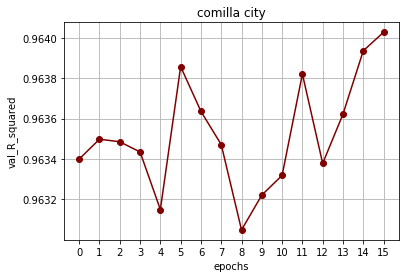

coxsbazar ******************************


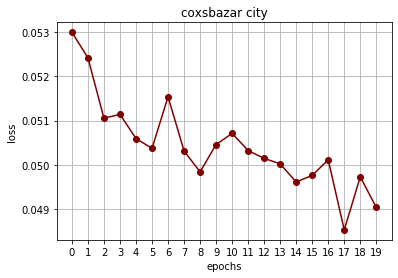

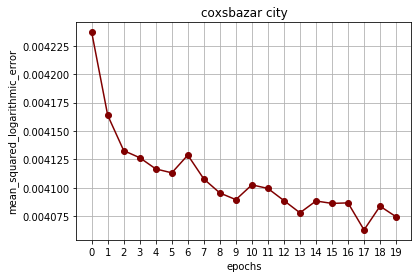

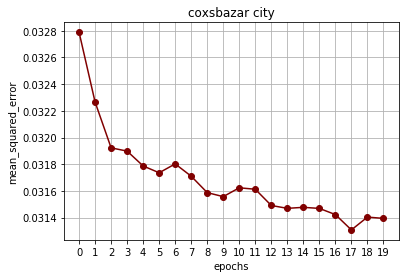

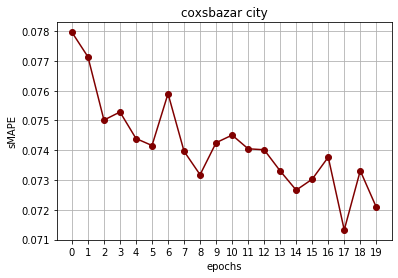

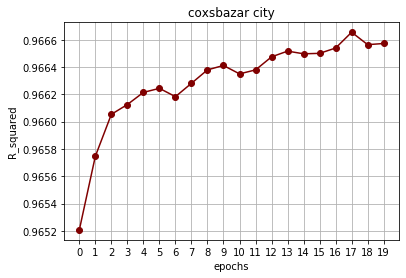

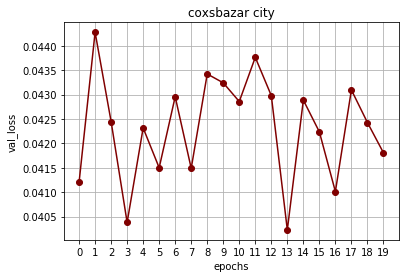

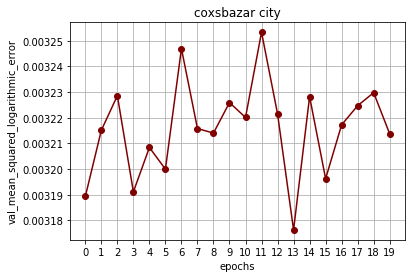

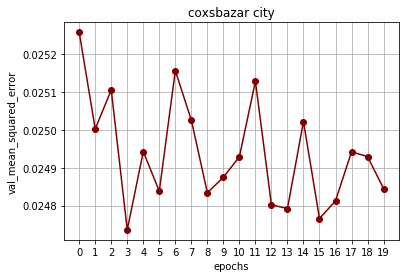

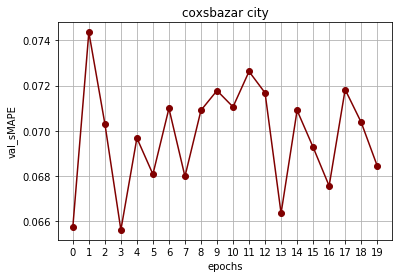

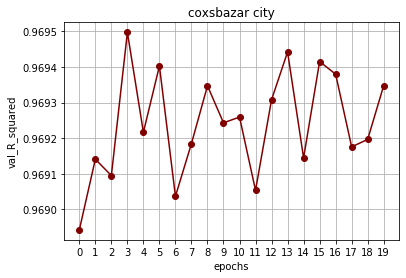

feni ******************************


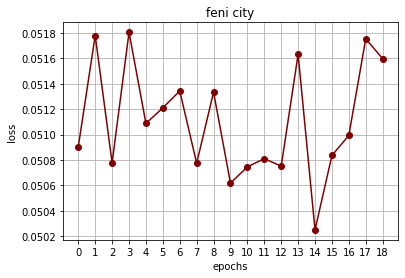

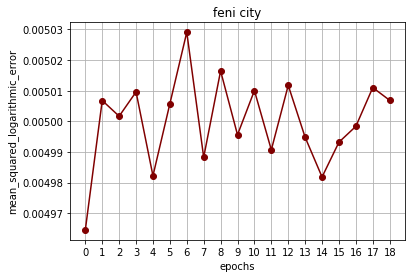

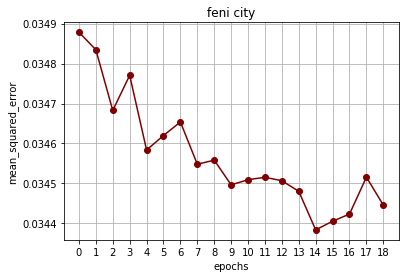

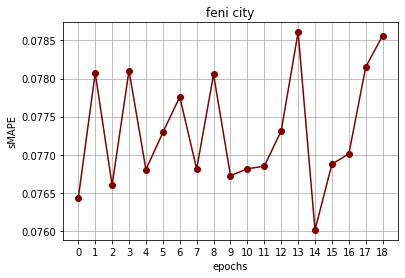

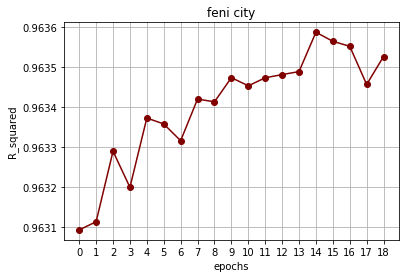

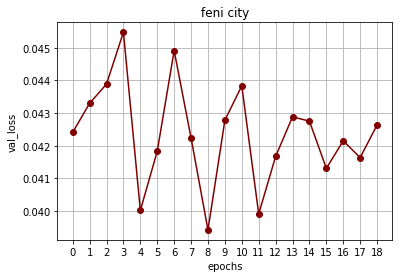

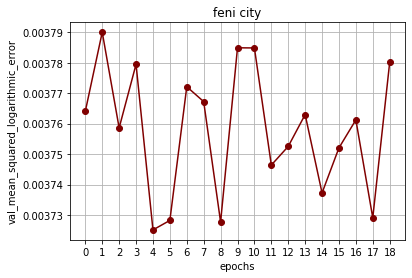

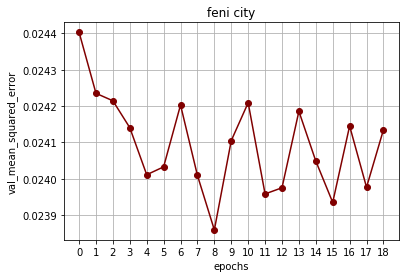

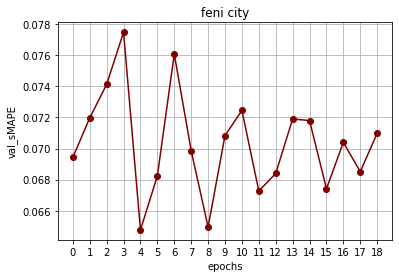

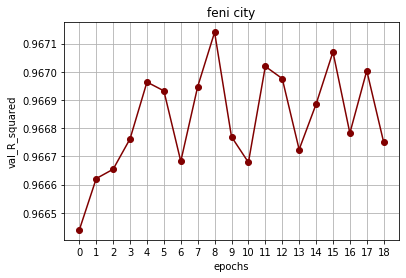

hatiya ******************************


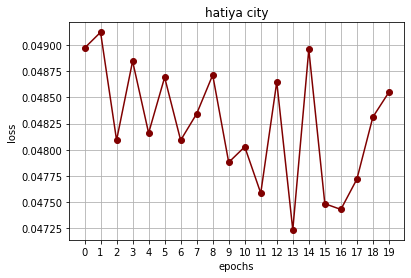

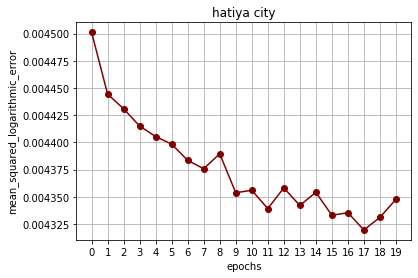

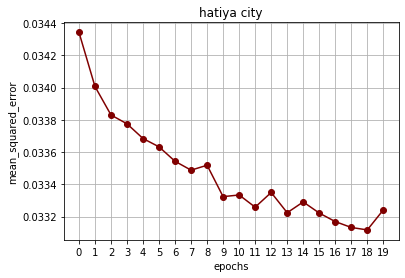

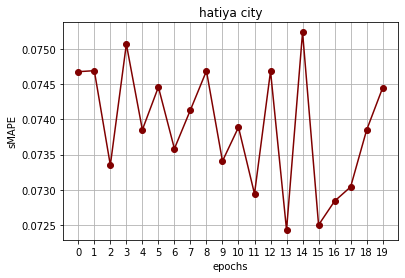

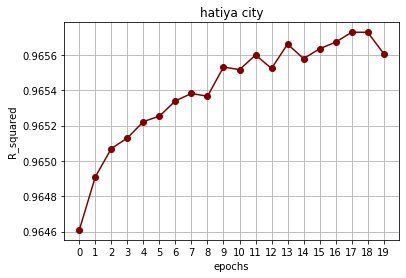

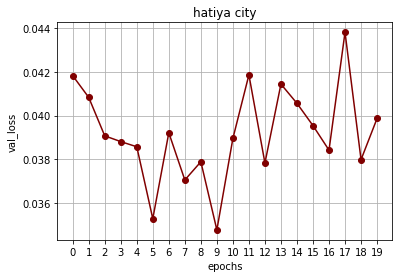

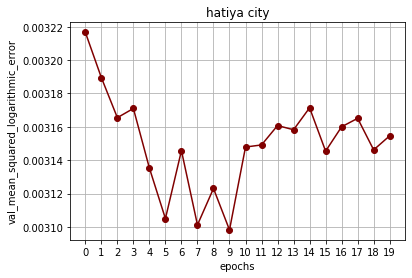

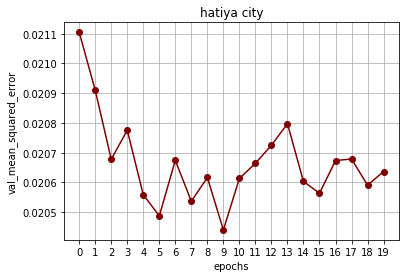

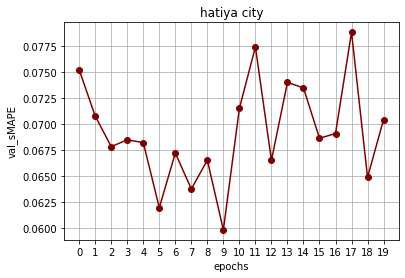

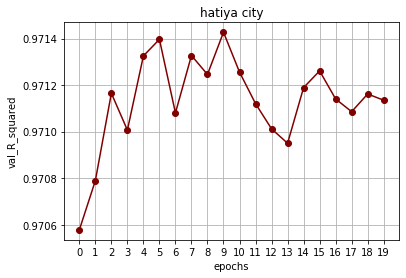

kutubdia ******************************


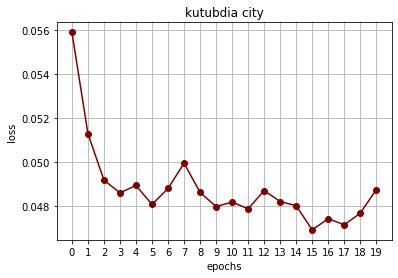

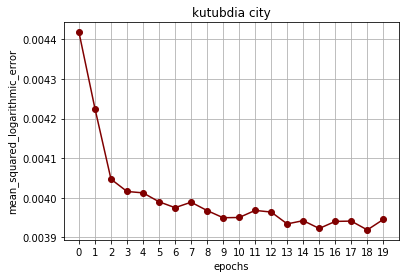

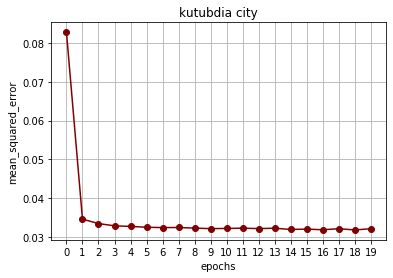

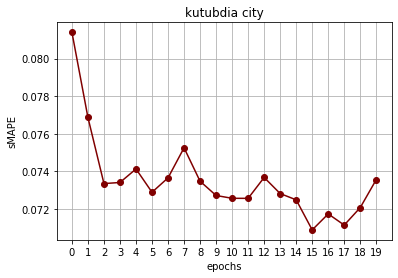

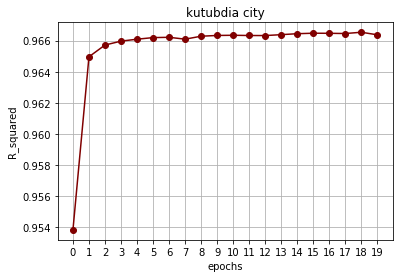

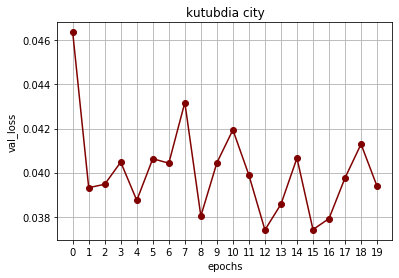

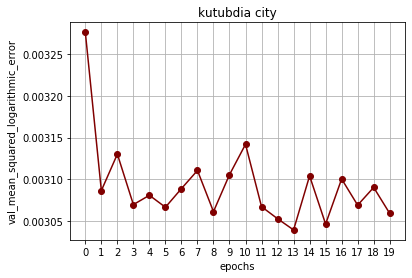

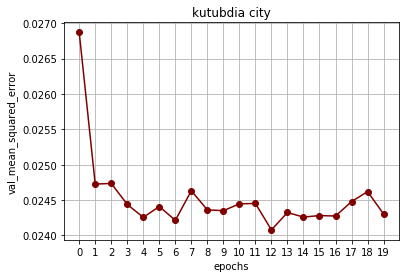

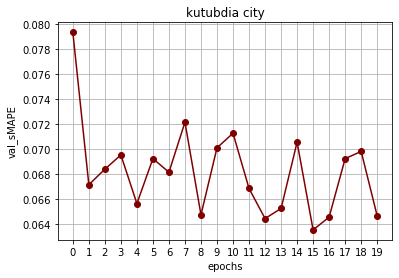

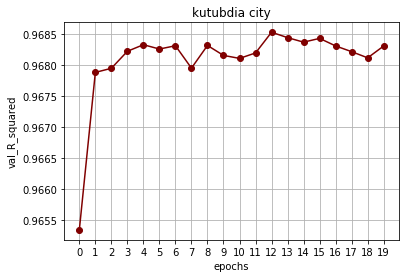

mcourt ******************************


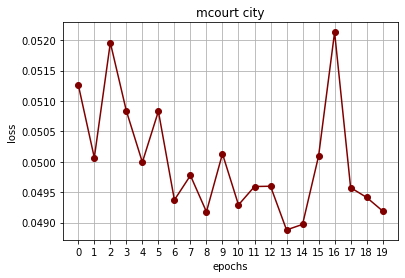

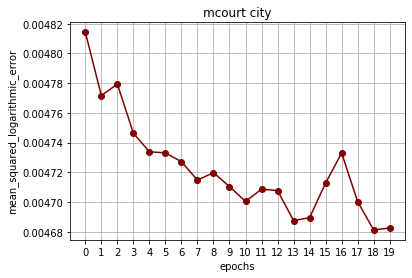

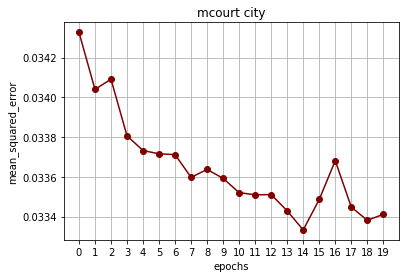

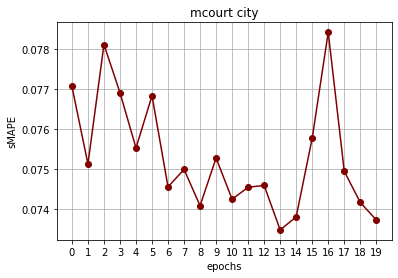

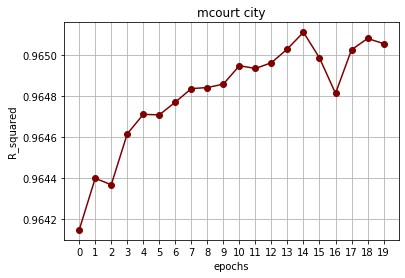

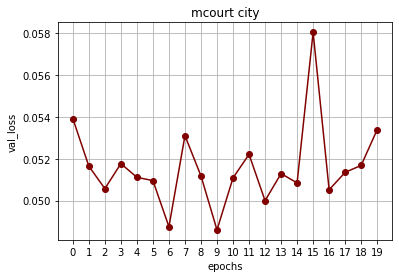

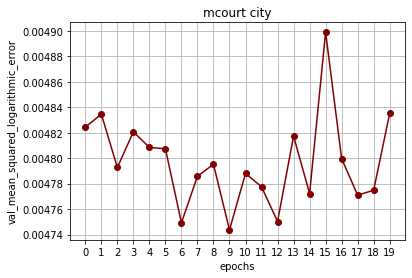

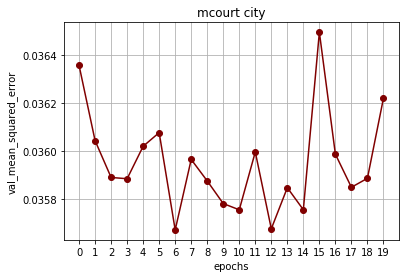

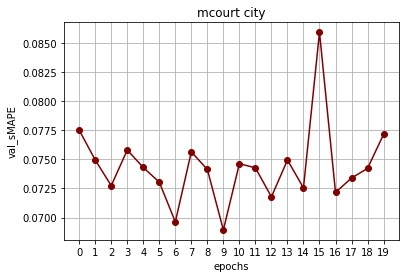

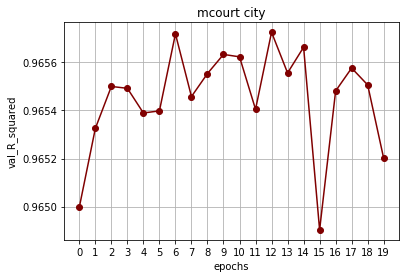

rangamati ******************************


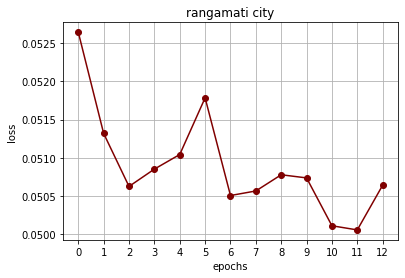

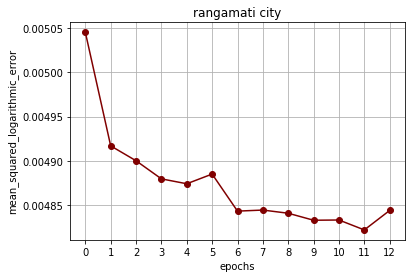

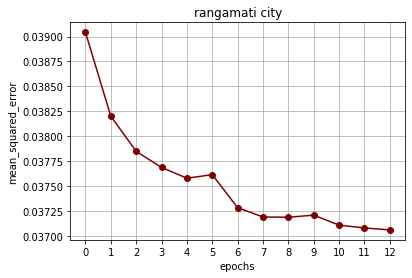

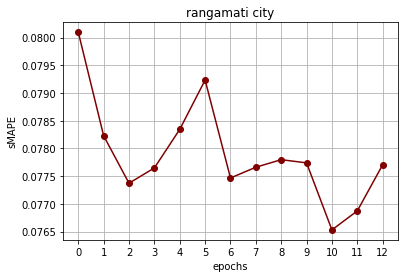

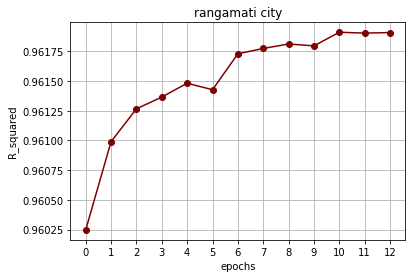

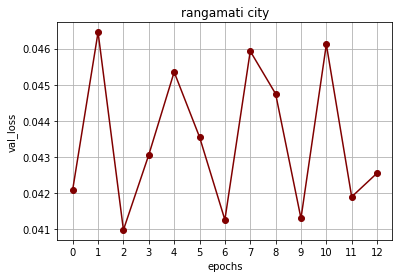

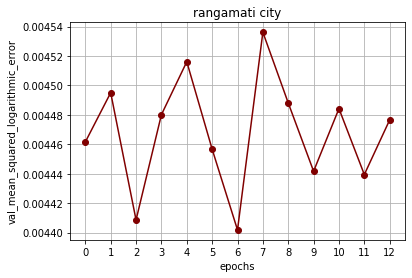

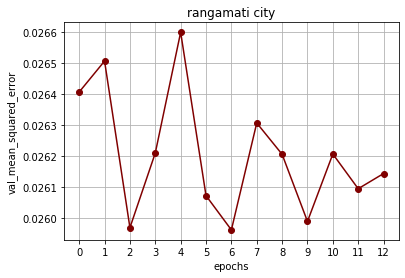

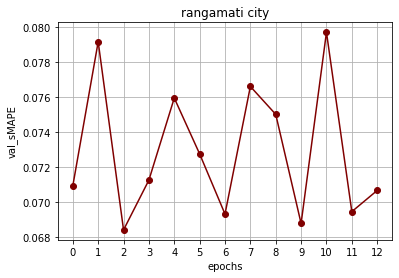

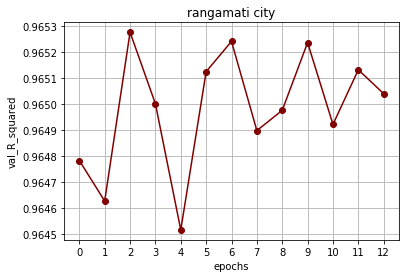

sandwip ******************************


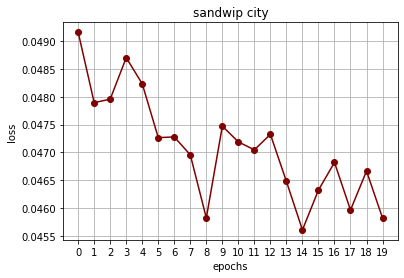

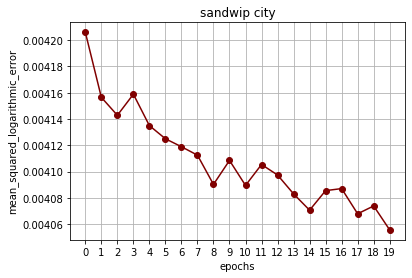

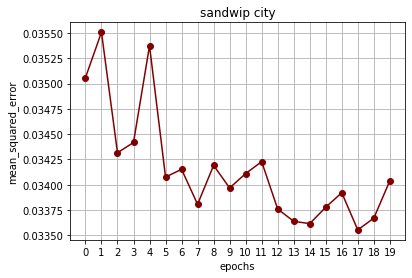

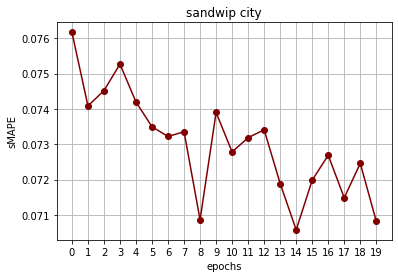

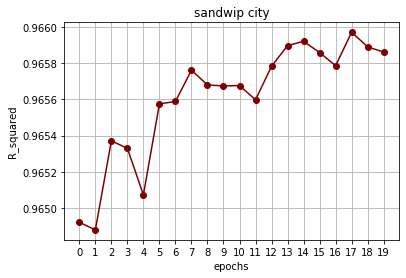

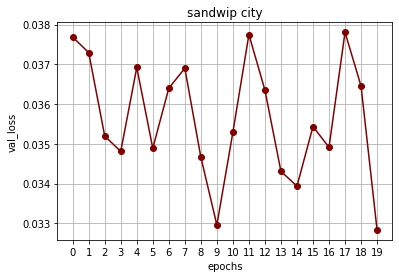

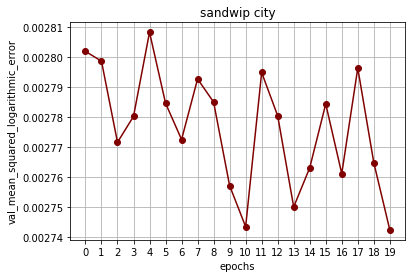

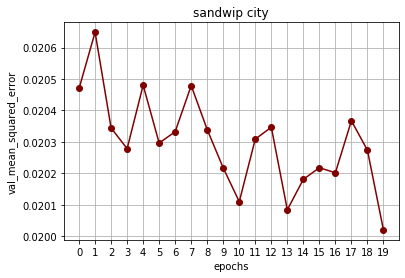

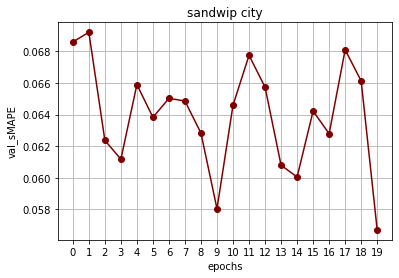

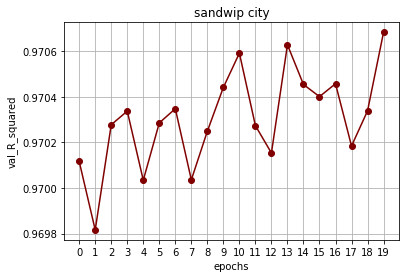

ambaganctg ******************************


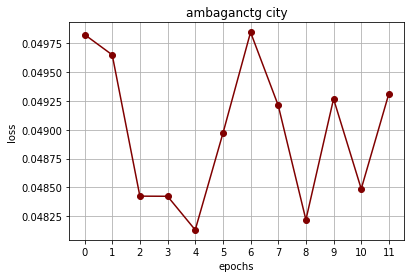

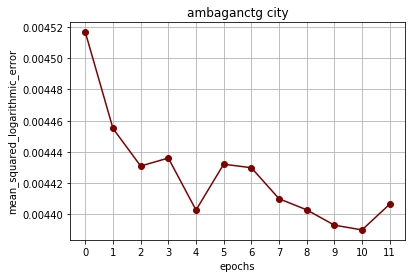

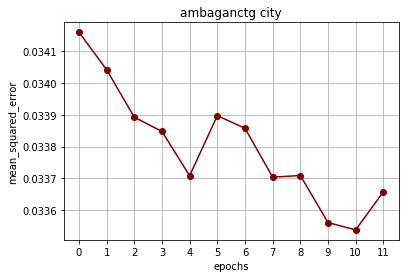

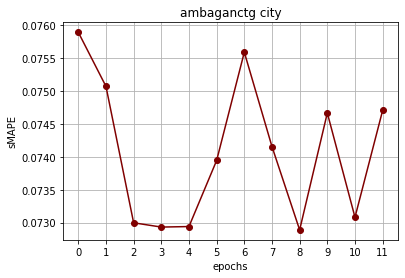

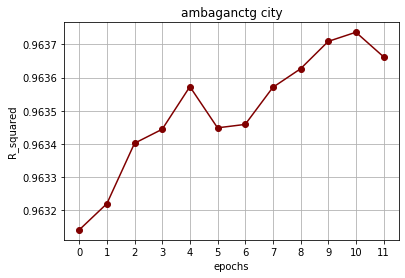

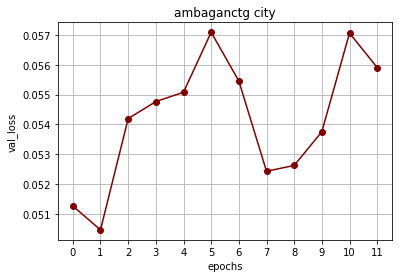

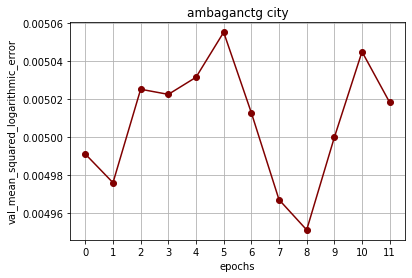

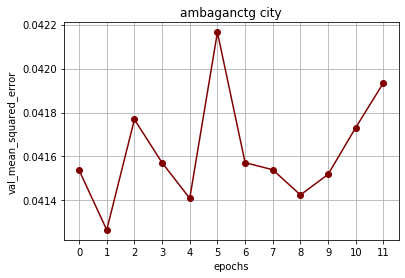

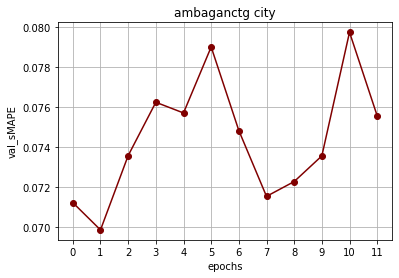

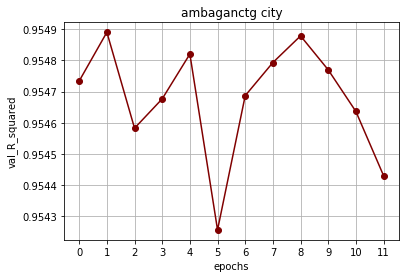

sitakunda ******************************


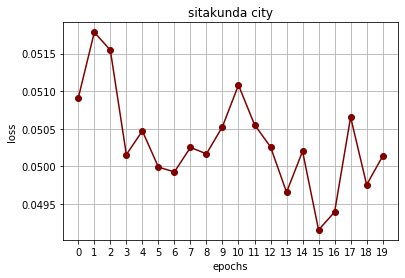

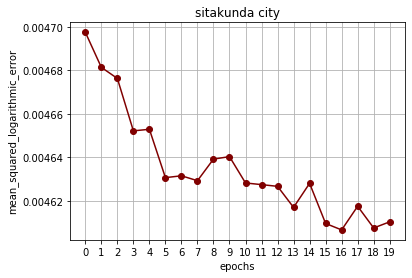

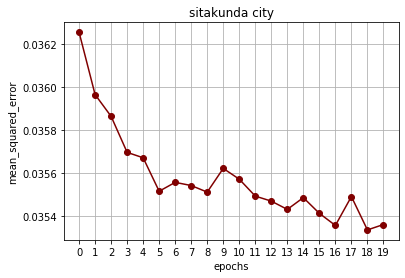

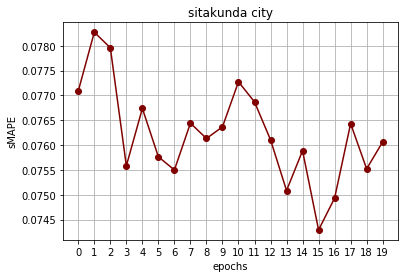

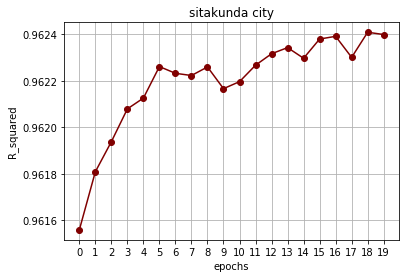

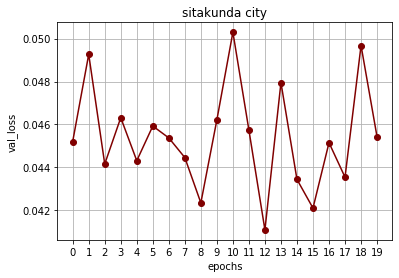

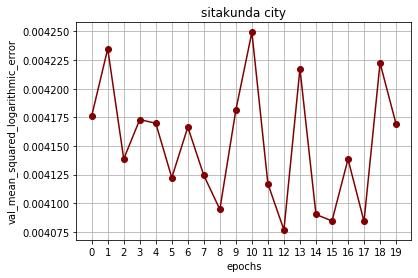

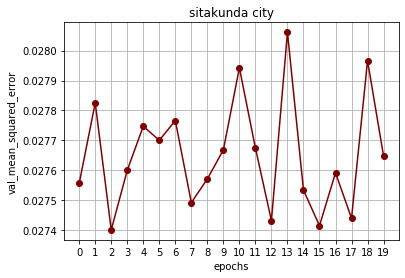

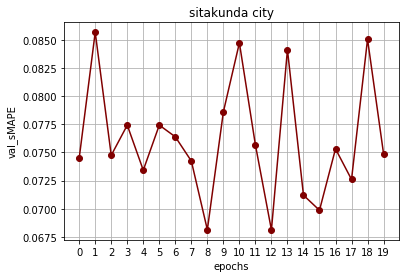

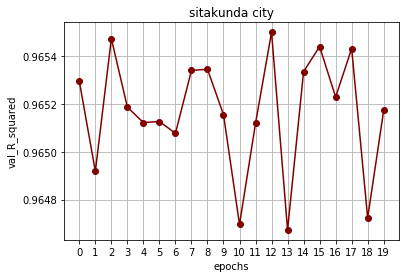

In [44]:
def draw(xAxis,yAxis,xname,yname,city):
    from matplotlib import pyplot as plt
    plt.grid(True)
    ## LINE GRAPH ##
    plt.title(city+" city")
    plt.plot(xAxis,yAxis, color='maroon', marker='o')
    plt.xlabel(xname)
    plt.ylabel(yname)

    ## BAR GRAPH ##
    #fig = plt.figure()
    #plt.bar(xAxis,yAxis, color='maroon')
    #plt.xlabel(xname)
    #plt.ylabel(yname)
    #C:\Users\Inception\Desktop\research\bd_weather_all\bd_weather_updated\BD_Weather\loss pic
    plt.savefig(ROOTPATH+"\loss_pic\\"+city+"_"+ yname+".png")
    plt.show()
import json
for city in cities:
    path=ROOTPATH+"\histories\history_lstm\Bi_LSTM_"+city+".json"
    dictionary = json.load(open(path, 'r'))
    print(city,"*"*30)
    for k,l in dictionary.items():
        xAxis = [key for key, value in dictionary[k].items()]
        yAxis = [value for key, value in dictionary[k].items()]
        draw(xAxis,yAxis,"epochs",k,city)

In [98]:
def r_squared_val(file_name):
    f1=open(file_name,"r").read().split("================== r^2 ==================")
    temp={}
    for x in f1[1].split("\n"):
        xx=x.split(":")
        if len(xx)>=2:
            #print(xx[1])
            temp[str(xx[0])]=str(xx[1].split("|")[1])
    return temp
def improvement_testing(file1,file2):
    improved=0
    not_improved=0
    t1=r_squared_val(file1)
    t2=r_squared_val(file2)
    for x in t1:
        if t1[x]>=t2[x]:
            print("improved    :",(float(t1[x])-float(t2[x]))*100)
            improved+=1
        else:
            print("not improved:",(float(t1[x])-float(t2[x]))*100)
            not_improved+=1
    print("improved:   :",improved)
    print("not improved:",not_improved)
f1=r"C:\Users\Administrator\Desktop\my research(Shakib)\BD_Weather\result/15_05_2022_15_24_02.txt"
f2=r"C:\Users\Administrator\Desktop\my research(Shakib)\BD_Weather\result\15_05_2022_10_03_52.txt"
improvement_testing(f1,f2)

not improved: -21.209999999999994
not improved: -4.810000000000003
not improved: -0.40000000000000036
not improved: -0.47000000000000375
not improved: -0.45999999999999375
not improved: -0.22999999999999687
not improved: -0.41999999999999815
not improved: -0.14999999999999458
improved    : 0.010000000000010001
not improved: -0.10000000000000009
not improved: -0.09000000000000119
improved    : 0.0
not improved: -0.17000000000000348
improved    : 0.0400000000000067
not improved: -0.08000000000000229
not improved: -0.10999999999999899
not improved: -0.11999999999999789
improved    : 0.009999999999998899
improved    : 0.009999999999998899
not improved: -0.019999999999997797
not improved: -0.04999999999999449
not improved: -0.050000000000005596
not improved: -0.04999999999999449
not improved: -0.08000000000000229
not improved: -0.09000000000000119
improved    : 0.030000000000007798
not improved: -0.029999999999996696
not improved: -0.039999999999995595
not improved: -0.20000000000000018
imp

{'dhaka                                             ': ' 0.9435',
 'tangail                                           ': ' 0.9572',
 'mymensingh                                        ': ' 0.9565',
 'faridpur                                          ': ' 0.9633',
 'madaripur                                         ': ' 0.9586',
 'srimangal                                         ': ' 0.9569',
 'sylhet                                            ': ' 0.9525',
 'bogra                                             ': ' 0.9586',
 'dinajpur                                          ': ' 0.9560',
 'ishurdi                                           ': ' 0.9642',
 'rajshahi                                          ': ' 0.9636',
 'rangpur                                           ': ' 0.9592',
 'sydpur                                            ': ' 0.9562',
 'chuadanga                                         ': ' 0.9617',
 'jessore                                           ': ' 0.9595',
 'khulna  